# 🎯 Few-shot fungi classification
This notebook provides a simple baselines for the few-shot classification of fungi. Both baselines require you to pre-extracted features using any encoder, e.g., BioCLIP, and DINOv2. For the classification, we provide:
1. **Centroid-based classifier** computes the class prototype by averaging the features of the support set. The class prototype is then used to classify the query set.
2. **Nearest neighbour classifier** classifies the query set by finding the nearest neighbour in the support set.

## ⚙️ Experiment Setup
Install and import for the required libraries. 
Setting up pathing etc.

We also set path to dataset (which are downloaded automatically).

In [1]:
###Install required libraries:
!pip install git+https://github.com/mlfoundations/open_clip.git
!pip install faiss-gpu -qq

  Cloning https://github.com/mlfoundations/open_clip.git to /tmp/pip-req-build-ix29q6oh
  Running command git clone --filter=blob:none --quiet https://github.com/mlfoundations/open_clip.git /tmp/pip-req-build-ix29q6oh
  Resolved https://github.com/mlfoundations/open_clip.git to commit 2eca151d2825075be52a3fe97a9da7939e657752
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
  Created wheel for open_clip_torch: filename=open_clip_torch-2.32.0-py3-none-any.whl size=1528818 sha256=63ea7023ee121ddb7778a65474255b6bf4a7399223dcae546f30d2a141d0d70f
  Stored in directory: /tmp/pip-ephem-wheel-cache-td73tly2/wheels/2c/7e/51/c9df485368875ebcc36099a02e2cb98922dec2cba6be26917f
Successfully built open_clip_torch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 20.8 MB/s eta 0:00:00


In [2]:
import os
import json
import yaml
from pathlib import Path
from types import SimpleNamespace
import argparse

import numpy as np
import pandas as pd
import torch
import faiss

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms as tfms
import torchvision.transforms as T
import open_clip

from typing import Sequence, Tuple, Any, Dict, List, Optional, Union
import importlib

In [3]:
# path to fungitatsic dataset
data_path = '/kaggle/input/fungi-clef-2025/'


## 🔬 1. Define BioCLIP feature extractor

### BioCLIP: A Deep Learning Model for Biological Image Feature Extraction

🔗 [BioCLIP](https://huggingface.co/imageomics/bioclip) is a deep learning model designed for extracting high-quality feature embeddings from biological images. It is built on the **Contrastive Language-Image Pretraining (CLIP) framework**, specifically tailored for biological applications. The model is hosted on the **Hugging Face Hub**, making it easily accessible for researchers and developers working with biological image data.

#### Purpose and Applications

BioCLIP is designed to bridge the gap between visual data and semantic understanding in biological research. Its main applications include:

- **Automated Species Identification**: Extracting meaningful features from images of fungi, plants, or animals to assist in species recognition.
- **Biodiversity Monitoring**: Enabling large-scale ecological studies by processing images from camera traps or field surveys.
- **Medical and Microscopy Analysis**: Supporting tasks like cell classification, pathology slide analysis, and disease detection.
- **Bioinformatics and AI-powered Conservation**: Facilitating the development of models that leverage image-based insights for conservation efforts.

#### Key Features

- **Pretrained on Biological Datasets**: Unlike general-purpose CLIP models, BioCLIP has been fine-tuned on biological image datasets, improving its performance in domain-specific tasks.
- **Feature Extraction for Downstream Tasks**: Generates robust, high-dimensional embeddings that can be used for classification, clustering, or retrieval.
- **L2-Normalized Embeddings**: Ensures that extracted feature vectors have unit length, making them suitable for similarity comparisons.
- **Seamless Integration with PyTorch**: Designed to work within PyTorch-based workflows for machine learning and deep learning applications.

#### Code and Implementation

The implementation of BioCLIP for feature extraction is available in the following repository:

This model can be integrated into Python workflows using `open_clip`, allowing users to load the model, preprocess images, and extract embeddings efficiently.

In [4]:
import torch
from PIL import Image
import open_clip

class BioCLIP(torch.nn.Module):
    def __init__(self, device):
        """
        Initialize the BioCLIP feature extractor.
        """
        super(BioCLIP, self).__init__()
        self.device = device
        self.model = None
        self.processor = None
        self.tokenizer = None
        self.size = (224, 224)

    def load(self):
        """
        Load the BioCLIP model and its associated processor and tokenizer.
        """
        self.model, _, self.processor = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
        self.tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')
        self.model.to(self.device)

    def extract_features(self, image):
        """
        Extract normalized image feature embeddings from a PIL image.
        """
        if self.model is None:
            raise ValueError('Model not loaded')
        image = image.resize(self.size, Image.BICUBIC)
        image_tensor_proc = self.processor(image)[None].to(self.device)
        features = self.model.encode_image(image_tensor_proc)
        return self.normalize_embedding(features)

    def extract_text_features(self, text_list):
        """
        Extract normalized text embeddings from a list of strings (e.g., sentences).

        Args:
            text_list (List[str]): A list of text inputs (sentences or captions).

        Returns:
            torch.Tensor: A tensor of shape [len(text_list), D] with normalized embeddings.
        """
        if self.model is None or self.tokenizer is None:
            raise ValueError('Model not loaded')
        with torch.no_grad():
            tokens = self.tokenizer(text_list).to(self.device)
            features = self.model.encode_text(tokens)
            return self.normalize_embedding(features)

    @staticmethod
    def normalize_embedding(embs):
        """
        Normalize the embedding vectors to unit L2 norm.
        """
        return torch.nn.functional.normalize(embs.float(), dim=1, p=2)

In [5]:
import torch
from PIL import Image
import open_clip

class SigCLIP(torch.nn.Module):
    def __init__(self, device):
        """
        Initialize the SigCLIP feature extractor.
        """
        super(SigCLIP, self).__init__()
        self.device = device
        self.model = None
        self.processor = None
        self.tokenizer = None
        self.size = (224, 224)

    def load(self):
        """
        Load the SigCLIP model and its associated processor and tokenizer.
        """
        self.model, _, self.processor = open_clip.create_model_and_transforms('hf-hub:timm/ViT-B-16-SigLIP')
        self.tokenizer = open_clip.get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')
        self.model.to(self.device)

    def extract_features(self, image):
        """
        Extract normalized image feature embeddings from a PIL image.
        """
        if self.model is None:
            raise ValueError('Model not loaded')
        image = image.resize(self.size, Image.BICUBIC)
        image_tensor_proc = self.processor(image)[None].to(self.device)
        features = self.model.encode_image(image_tensor_proc)
        return self.normalize_embedding(features)

    def extract_text_features(self, text_list):
        """
        Extract normalized text embeddings from a list of strings (e.g., sentences).

        Args:
            text_list (List[str]): A list of text inputs.

        Returns:
            torch.Tensor: A tensor of shape [len(text_list), D] with normalized embeddings.
        """
        if self.model is None or self.tokenizer is None:
            raise ValueError('Model not loaded')
        with torch.no_grad():
            tokens = self.tokenizer(text_list).to(self.device)
            features = self.model.encode_text(tokens)
            return self.normalize_embedding(features)

    @staticmethod
    def normalize_embedding(embs):
        """
        Normalize the embedding vectors to unit L2 norm.
        """
        return torch.nn.functional.normalize(embs.float(), dim=1, p=2)

## 📙 2. Define dataset class for FungiTastic

`FungiTastic` is a PyTorch dataset class designed for handling the **Few-Shot subset** of the Danish Fungi dataset, with support for **train, validation, and test splits**. The class allows for efficient data handling, including image loading, embedding management, and transformation application.

#### Key Features:
- **Dataset Initialization**: Loads metadata (e.g., file paths, class IDs) from CSV files. Supports splits (`train`, `val`, `test`) and applies optional image transformations.
- **Embedding Handling**: Adds precomputed embeddings to the dataset and allows retrieval of embeddings for specific classes.
- **Data Access**: Implements the `__getitem__()` method to fetch images, class IDs, and file paths. It also returns embeddings if available.
- **Class Mapping**: Maps class IDs to species names and allows retrieving the category of samples by ID.
- **Sample Visualization**: Provides the `show_sample()` method to display images along with their class labels.

#### Functions:
- **`add_embeddings(embeddings)`**: Merges new embeddings with the dataset.
- **`get_embeddings_for_class(id)`**: Retrieves embeddings for a given class ID.
- **`_get_df(data_path, split)`**: Loads the dataset metadata into a pandas DataFrame.
- **`__getitem__(idx)`**: Fetches a sample by index, including image, category ID, and embedding (if available).
- **`__len__()`**: Returns the total number of samples in the dataset.
- **`get_class_id(idx)`**: Retrieves the class ID for a specific sample.
- **`show_sample(idx)`**: Displays an image with its associated class label.


In [6]:
import os
import random
from typing import List, Dict, Any, Optional, Tuple
from PIL import Image
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import re

class FungiTasticAugmented(torch.nn.Module):
    SPLIT2STR = {'train': 'Train', 'val': 'Val', 'test': 'Test'}
    
    def __init__(self, root: str, split: str = 'val', transform=None,
                 augment_transform=None, num_augments: int = 0):
        super().__init__()
        self.root = root
        self.split = split
        self.transform = transform
        self.augment_transform = augment_transform
        self.num_augments = num_augments if split == 'train' else 0
        
        # Cache for one-hot encodings schema (filled during first use)
        self._month_categories = None
        self._habitat_categories = None
        self._substrate_categories = None
        
        # Load and process the DataFrame
        self.df = self._get_df(root, split)
        
        # Create one-hot encodings for month, habitat, and substrate
        self.df = self._add_onehot_encodings(self.df)
        
        # Build augmented dataframe if needed
        self.df = self._build_augmented_df(self.df)
        
        if split != 'test':
            self.n_classes = len(self.df['category_id'].unique())
            self.category_id2label = {
                k: v[0] for k, v in self.df.groupby('category_id')['species'].unique().to_dict().items()
            }
            self.label2category_id = {v: k for k, v in self.category_id2label.items()}
    
    def _get_df(self, data_path: str, split: str) -> pd.DataFrame:
        df_path = os.path.join(
            data_path,
            "metadata",
            "FungiTastic-FewShot",
            f"FungiTastic-FewShot-{self.SPLIT2STR[split]}.csv"
        )
        df = pd.read_csv(df_path)
        df["image_path"] = df.filename.apply(
            lambda x: os.path.join(data_path, "FungiTastic-FewShot", split, '300p', x)
        )
        return df
    
    def _add_onehot_encodings(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add one-hot encodings for month, habitat, and substrate columns.
        Uses the schema from the training set for consistent dimensionality
        across train, val, and test splits.
        """
        # Handle potential NaN values in categorical columns
        df['month'] = df['month'].fillna('unknown_month')
        df['habitat'] = df['habitat'].fillna('unknown_habitat')
        df['substrate'] = df['substrate'].fillna('unknown_substrate')
        
        # For consistency, we need to get the schema from the training CSV
        # regardless of which split we're currently processing
        train_df_path = os.path.join(
            self.root,
            "metadata",
            "FungiTastic-FewShot",
            f"FungiTastic-FewShot-{self.SPLIT2STR['train']}.csv"
        )
        train_df = pd.read_csv(train_df_path)
        
        # Fill NaN values in the train dataframe
        train_df['month'] = train_df['month'].fillna('unknown_month')
        train_df['habitat'] = train_df['habitat'].fillna('unknown_habitat')
        train_df['substrate'] = train_df['substrate'].fillna('unknown_substrate')
        
        # Get the categorical values from the training set
        month_categories = sorted(train_df['month'].unique())
        habitat_categories = sorted(train_df['habitat'].unique())
        substrate_categories = sorted(train_df['substrate'].unique())
        
        # Create one-hot encodings for the current dataframe based on training schema
        month_onehot = pd.get_dummies(df['month'], prefix='month')
        habitat_onehot = pd.get_dummies(df['habitat'], prefix='habitat')
        substrate_onehot = pd.get_dummies(df['substrate'], prefix='substrate')
        
        # Make sure all columns from training set are present
        for month in month_categories:
            col_name = f'month_{month}'
            if col_name not in month_onehot.columns:
                month_onehot[col_name] = 0
                
        for habitat in habitat_categories:
            col_name = f'habitat_{habitat}'
            if col_name not in habitat_onehot.columns:
                habitat_onehot[col_name] = 0
                
        for substrate in substrate_categories:
            col_name = f'substrate_{substrate}'
            if col_name not in substrate_onehot.columns:
                substrate_onehot[col_name] = 0
        
        # Sort columns to ensure consistent ordering
        month_onehot = month_onehot.reindex(sorted(month_onehot.columns), axis=1)
        habitat_onehot = habitat_onehot.reindex(sorted(habitat_onehot.columns), axis=1)
        substrate_onehot = substrate_onehot.reindex(sorted(substrate_onehot.columns), axis=1)
        
        # Combine the original dataframe with one-hot encoded columns
        result_df = pd.concat([df, month_onehot, habitat_onehot, substrate_onehot], axis=1)
        
        # Store metadata dimensions for easy access
        self.month_dims = len(month_categories)
        self.habitat_dims = len(habitat_categories)
        self.substrate_dims = len(substrate_categories)
        self.metadata_dims = self.month_dims + self.habitat_dims + self.substrate_dims
        
        # Store column names for later use
        self.month_cols = sorted([f'month_{m}' for m in month_categories])
        self.habitat_cols = sorted([f'habitat_{h}' for h in habitat_categories])
        self.substrate_cols = sorted([f'substrate_{s}' for s in substrate_categories])
        self.metadata_cols = self.month_cols + self.habitat_cols + self.substrate_cols
        
        return result_df
    
    def _build_augmented_df(self, base_df: pd.DataFrame) -> pd.DataFrame:
        """Extend the dataframe to include augmented samples."""
        if self.num_augments == 0:
            return base_df.copy()
        
        aug_rows = []
        for _, row in base_df.iterrows():
            for i in range(self.num_augments):
                aug_row = row.copy()
                aug_row['filename'] = f"{row['filename'].rsplit('.', 1)[0]}_aug{i}.jpg"
                aug_row['image_path'] = row['image_path']
                aug_rows.append(aug_row)
                
        aug_df = pd.DataFrame(aug_rows)
        full_df = pd.concat([base_df, aug_df], ignore_index=True)
        return full_df

    def _load_caption(self, filename: str) -> Optional[str]:
        """Load caption from JSON file for the given filename."""
        # Remove _aug<number>.jpg and replace with .PNG
        filename = re.sub(r'_aug\d+\.jpg$', '.JPG', filename)
    
        json_name = f"{filename}.json"
        caption_path = os.path.join(self.root, 'captions', self.split, json_name)
    
        if os.path.exists(caption_path):
            with open(caption_path, 'r') as f:
                return json.load(f)
        return None
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Optional[int], str, Optional[torch.Tensor], torch.Tensor]:
        row = self.df.iloc[idx]
        file_path = row["image_path"].replace('FungiTastic-FewShot', 'images/FungiTastic-FewShot')
        image = Image.open(file_path).convert("RGB")
        
        is_aug = '_aug' in row["filename"]
        if is_aug and self.augment_transform:
            image = self.augment_transform(image)
        elif self.transform:
            image = self.transform(image)
        
        # Get one-hot encoded metadata features
        metadata_features = torch.tensor(
            row[self.metadata_cols].values.astype(np.float32),
            dtype=torch.float32
        )
        
        category_id = row["category_id"] if self.split != 'test' else None
        caption = self._load_caption(row["filename"])

        if not caption or caption.isspace():
            caption = (
                f"A mushroom found in {row['habitat']} on {row['substrate']} during {row['month']}."
            )
        
        # Handle embeddings if available
        if "embedding" in self.df.columns:
            emb = torch.tensor(row['embedding'], dtype=torch.float32).squeeze()
        else:
            emb = None
        
        return image, category_id, row["filename"], caption, metadata_features, emb
    
    def __len__(self):
        return len(self.df)
    
    def add_embeddings(self, embeddings: pd.DataFrame):
        assert "filename" in embeddings.columns and "embedding" in embeddings.columns
        self.df = pd.merge(self.df, embeddings, on="filename", how="inner")
    
    def get_embeddings_for_class(self, id):
        class_idxs = self.df[self.df['category_id'] == id].index
        return self.df.iloc[class_idxs]['embedding']
    
    def get_category_idxs(self, category_id: int) -> List[int]:
        return self.df[self.df.category_id == category_id].index.tolist()
    
    def get_class_id(self, idx: int) -> int:
        return self.df["category_id"].iloc[idx]
    
    def get_metadata_features(self, idx: int) -> torch.Tensor:
        """Get only the metadata features for a specific sample."""
        row = self.df.iloc[idx]
        return torch.tensor(row[self.metadata_cols].values.astype(np.float32), dtype=torch.float32)
    
    def get_month_features(self, idx: int) -> torch.Tensor:
        """Get only the month one-hot features for a specific sample."""
        row = self.df.iloc[idx]
        return torch.tensor(row[self.month_cols].values.astype(np.float32), dtype=torch.float32)
    
    def get_habitat_features(self, idx: int) -> torch.Tensor:
        """Get only the habitat one-hot features for a specific sample."""
        row = self.df.iloc[idx]
        return torch.tensor(row[self.habitat_cols].values.astype(np.float32), dtype=torch.float32)
    
    def get_substrate_features(self, idx: int) -> torch.Tensor:
        """Get only the substrate one-hot features for a specific sample."""
        row = self.df.iloc[idx]
        return torch.tensor(row[self.substrate_cols].values.astype(np.float32), dtype=torch.float32)
    
    def show_sample(self, idx: int):
        """Display a sample image with its metadata information."""
        image, category_id, _, caption, metadata, _ = self.__getitem__(idx)
        row = self.df.iloc[idx]
        
        # Convert to PIL if it's a tensor
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
            
        class_name = self.category_id2label[category_id] if self.split != 'test' else "Unknown (Test)"
        
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 1, 1)
        plt.imshow(image)
        plt.title(f"Class: {class_name}; ID: {idx}")
        
        # Add metadata info in the figure
        info_text = f"Month: {row['month']}\n"
        info_text += f"Habitat: {row['habitat']}\n"
        info_text += f"Substrate: {row['substrate']}\n"
        stop_idx = min(
            (i for i in [caption.find('.'), caption.find('\n'), 100] if i != -1),
            default=100
        )
        snippet = caption[:stop_idx + 1].rstrip('\n')
        info_text += f"Caption: {snippet}"
        
        plt.figtext(0.5, 0.01, info_text, ha="center", fontsize=10, 
                   bbox={"facecolor":"white", "alpha":0.8, "pad":5})
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [7]:
from torchvision import transforms

augment_transform = transforms.Compose([
    # Randomly crop and resize the image to the target size
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    
    # Random horizontal flip for augmentation
    transforms.RandomHorizontalFlip(p=0.5),
])

# train_dataset = FungiTasticAugmented(root=data_path, split='train', 
#                                      transform=augment_transform,
#                                     num_augments=3)
train_dataset = FungiTasticAugmented(root=data_path, split='train', transform=None)
test_dataset = FungiTasticAugmented(root=data_path, split='test', transform=None)
val_dataset = FungiTasticAugmented(root=data_path, split='val', transform=None)

train_dataset.df.head(5)

,eventDate,year,month,day,habitat,countryCode,scientificName,kingdom,phylum,class,...,substrate_peat mosses,substrate_remains of vertebrates (e.g. feathers and fur),substrate_siliceous stone,substrate_soil,substrate_spiders,"substrate_stems of herbs, grass etc",substrate_stone,substrate_unknown_substrate,substrate_wood and roots of living trees,substrate_wood chips or mulch
0,2021-01-24,2021,1.0,24.0,Mixed woodland (with coniferous and deciduous ...,DK,Xylohypha ferruginosa (Corda) S.Hughes,Fungi,Ascomycota,Eurotiomycetes,...,False,False,False,False,False,False,False,False,False,False
1,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,False,False,False,False,False,False,False,False,False,False
2,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,False,False,False,False,False,False,False,False,False,False
3,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,False,False,False,False,False,False,False,False,False,False
4,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,False,False,False,False,False,False,False,False,False,False


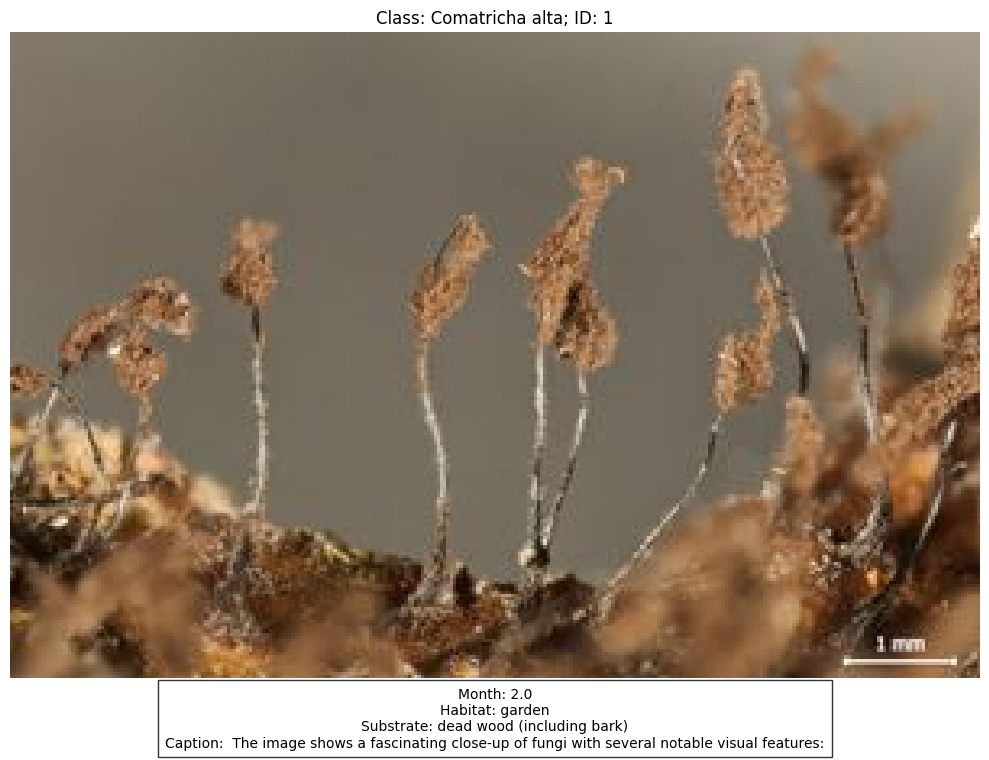

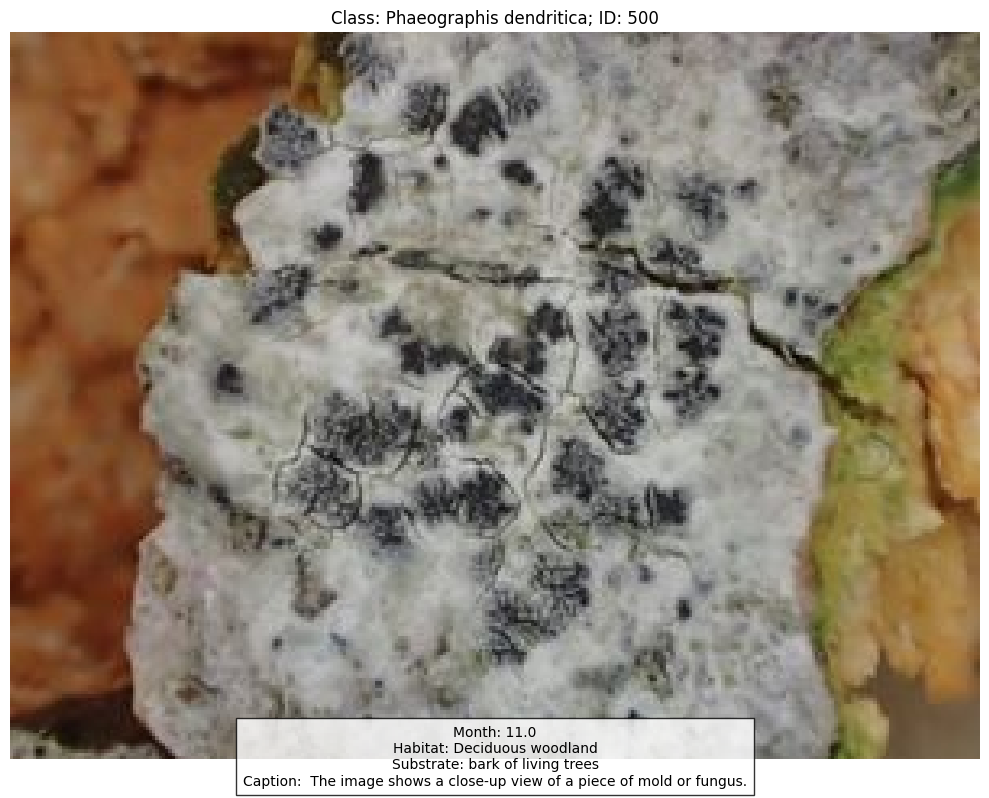

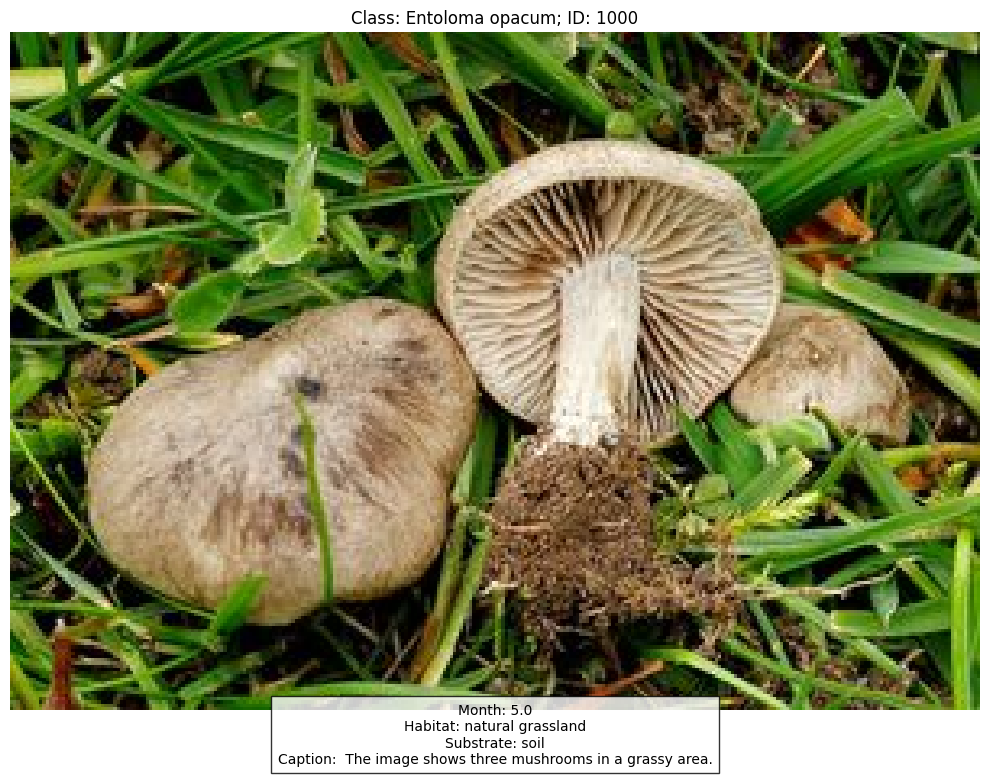

(None, None, None)

In [8]:
### Visualize few samples

train_dataset.show_sample(1), train_dataset.show_sample(500), train_dataset.show_sample(1000)

In [9]:
# train_dataset.show_sample(10000), train_dataset.show_sample(15000), train_dataset.show_sample(20000)

## ⏳ 3. Precompute embeddings using BioCLIP

This code snippet demonstrates how to precompute image embeddings using the **BioCLIP** model. It loads the BioCLIP model, processes a given dataset, and stores the generated embeddings.

#### Steps:
1. **Initialize the Model**: The code sets up the **BioCLIP** model on the available device (GPU if available, else CPU). The model is then loaded and set to evaluation mode (`model.eval()`).
2. **Generate Embeddings**: 
   - The `generate_embeddings()` function loops through all the samples in the dataset.
   - For each image, it extracts the feature embeddings using `model.extract_features()`.
   - The extracted embeddings are stored in a pandas DataFrame with the image filename.
3. **Add Embeddings to Dataset**: The generated embeddings are then added to the respective dataset (`test_dataset` and `train_dataset`) using the `add_embeddings()` method.

#### Key Components:
- **BioCLIP model**: Used to extract embeddings for each image in the dataset.
- **Data Handling**: `im_names` stores image filenames, and `embs` stores the corresponding embeddings.
- **Embedding Storage**: Embeddings are stored in a pandas DataFrame, which is later merged with the dataset.

This process enables efficient embedding-based learning and retrieval tasks on the dataset.


In [10]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torchvision import transforms as TF
from datetime import datetime
from transformers import AutoImageProcessor, AutoModel, SiglipVisionModel, SiglipImageProcessor
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# ======= Device Setup =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= Load BioCLIP (custom class assumed) =======
bioclip_model = BioCLIP(device=device)
bioclip_model.load()
bioclip_model.eval()

# ======= Load SigLIP (instead of ConvNeXt) =======
siglip_model = SigCLIP(device=device)
siglip_model.load()
siglip_model.eval()

# ======= Load DINOv2 Base =======
dinov2_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dinov2_model = AutoModel.from_pretrained("facebook/dinov2-base", torch_dtype=torch.float32).to(device)
dinov2_model.eval()

# ======= BioCLIP Embedding =======
def generate_bioclip_embeddings(dataset):
    bio_embs, im_names = [], []
    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc="BioCLIP"):
            im, _, file_path, _, _, _ = dataset[idx]
            im_pil = TF.to_pil_image(im) if isinstance(im, torch.Tensor) else im.convert("RGB")
            bio_feat = bioclip_model.extract_features(im_pil).squeeze(0)
            bio_embs.append(bio_feat.cpu().numpy())
            im_names.append(os.path.basename(file_path))
    
    bio_embeddings = pd.DataFrame({'filename': im_names, 'embedding': [e.tolist() for e in bio_embs]})
    return bio_embeddings

# ======= SigLIP Embedding =======
def generate_siglip_embeddings(dataset):
    sig_embs, im_names = [], []
    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc="SigLIP"):
            im, _, file_path, _, _, _ = dataset[idx]
            im_pil = TF.to_pil_image(im) if isinstance(im, torch.Tensor) else im.convert("RGB")
            siglip_feat = siglip_model.extract_features(im_pil).squeeze(0)
            sig_embs.append(siglip_feat.cpu().numpy())
            im_names.append(os.path.basename(file_path))
    
    siglip_embeddings = pd.DataFrame({'filename': im_names, 'embedding': [e.tolist() for e in sig_embs]})
    return siglip_embeddings

# ======= DINOv2 Embedding =======
def generate_dinov2_embeddings(dataset):
    dino_embs, im_names = [], []
    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc="DINOv2"):
            im, _, file_path, _, _, _ = dataset[idx]
            im_pil = TF.to_pil_image(im) if isinstance(im, torch.Tensor) else im.convert("RGB")
            dino_inputs = dinov2_processor(images=im_pil, return_tensors="pt").to(device)
            dino_feat = dinov2_model(**dino_inputs).last_hidden_state.mean(dim=1).squeeze(0)
            dino_embs.append(dino_feat.cpu().numpy())
            im_names.append(os.path.basename(file_path))
    
    dinov2_embeddings = pd.DataFrame({'filename': im_names, 'embedding': [e.tolist() for e in dino_embs]})
    return dinov2_embeddings

def generate_image_embeddings(dataset):
    idxs = np.arange(len(dataset))
    im_names, embs = [], []

    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")

    with torch.no_grad():
        for idx in tqdm(idxs):
            im, label, file_path, _, _, _ = dataset[idx]
            im_pil = TF.to_pil_image(im) if isinstance(im, torch.Tensor) else im.convert("RGB")

            # --- BioCLIP ---
            bio_feat = bioclip_model.extract_features(im_pil).squeeze(0)
            bio_feat = bio_feat.squeeze(0)

            # --- SigLIP ---
            siglip_feat = siglip_model.extract_features(im_pil).squeeze(0)
            siglip_feat = siglip_feat.squeeze(0)

            # --- DINOv2 ---
            dino_inputs = dinov2_processor(images=im_pil, return_tensors="pt").to(device)
            dino_feat = dinov2_model(**dino_inputs).last_hidden_state.mean(dim=1).squeeze(0)

            # --- Concatenate ---
            combined = torch.cat([bio_feat, siglip_feat, dino_feat], dim=0).cpu().numpy()
            embs.append(combined)
            im_names.append(os.path.basename(file_path))

    embeddings = pd.DataFrame({'filename': im_names, 'embedding': [e.tolist() for e in embs]})
    return embeddings

open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

open_clip_model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [11]:
import re
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are downloaded
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

class FungiTextFeatureExtractor:
    """Pipeline to extract classification-relevant features from fungi descriptions."""
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Define taxonomic feature dictionaries
        self.color_terms = {
            'white': 0, 'cream': 1, 'yellow': 2, 'orange': 3, 'red': 4, 
            'pink': 5, 'purple': 6, 'blue': 7, 'green': 8, 'brown': 9, 
            'black': 10, 'gray': 11, 'grey': 11, 'tan': 12, 'golden': 13,
            'beige': 14, 'buff': 15, 'olive': 16, 'rusty': 17
        }
        
        self.shape_terms = {
            'spherical': 0, 'round': 0, 'globose': 0, 'ball': 0,
            'cap': 1, 'pileus': 1, 'umbrella': 1, 
            'conical': 2, 'cone': 2,
            'flat': 3, 'convex': 4, 'depressed': 5, 
            'shelf': 6, 'bracket': 6,
            'club': 7, 'coral': 8, 'fan': 9,
            'cup': 10, 'disc': 11, 'bell': 12
        }
        
        self.texture_terms = {
            'smooth': 0, 'slimy': 1, 'sticky': 2, 'viscid': 2, 
            'rough': 3, 'bumpy': 3, 'warty': 3, 'scaly': 4, 
            'fibrous': 5, 'hairy': 6, 'velvety': 7, 'fuzzy': 8,
            'ridged': 9, 'wrinkled': 10, 'grooved': 11, 'pitted': 12,
            'powdery': 13, 'granular': 14, 'cracked': 15
        }
        
        self.growth_terms = {
            'cluster': 0, 'clustered': 0, 'group': 0, 'gregarious': 0,
            'scattered': 1, 'solitary': 2, 'single': 2, 'individual': 2,
            'caespitose': 3, 'troops': 4, 'fairy ring': 5, 'circle': 5,
            'row': 6, 'line': 6, 'tuft': 7, 'dense': 8, 'packed': 8
        }
        
        self.habitat_terms = {
            'soil': 0, 'ground': 0, 'earth': 0,
            'wood': 1, 'log': 1, 'trunk': 1, 'stump': 1, 'branch': 1,
            'leaf': 2, 'leaves': 2, 'needle': 2, 'needles': 2, 'litter': 2,
            'moss': 3, 'grass': 4, 'dung': 5, 'manure': 5, 
            'compost': 6, 'mulch': 7
        }
        
        # Technical mycological terms vectorizer
        self.mycological_terms = [
            'mycelium', 'hyphae', 'spore', 'fruiting body', 'basidium', 'basidia',
            'ascus', 'asci', 'cystidia', 'stipe', 'pileus', 'lamellae', 'gills',
            'pores', 'annulus', 'volva', 'universal veil', 'partial veil',
            'hymenium', 'cap', 'stem', 'stalk'
        ]
        
        # Initialize TF-IDF vectorizer for general text features
        self.tfidf = TfidfVectorizer(
            max_features=50,
            ngram_range=(1, 2),
            stop_words='english'
        )
        
    def preprocess_text(self, text):
        """Clean and normalize text."""
        # Convert to lowercase
        text = text.lower()
        
        # Remove non-alphabetic characters but keep spaces
        text = re.sub(r'[^a-z\s]', ' ', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        clean_tokens = [
            self.lemmatizer.lemmatize(token) 
            for token in tokens 
            if token not in self.stop_words and len(token) > 2
        ]
        
        return ' '.join(clean_tokens)
    
    def extract_color_features(self, text):
        """Extract color-related features."""
        # Initialize feature vector with zeros
        color_vector = np.zeros(len(set(self.color_terms.values())))
        
        # Find all color terms in text
        for color, idx in self.color_terms.items():
            if re.search(r'\b' + color + r'\b', text.lower()):
                color_vector[idx] = 1
                
        # Add intensity information
        intensity_terms = ['light', 'pale', 'dark', 'deep', 'bright', 'dull']
        intensity_vector = np.zeros(len(intensity_terms))
        
        for i, term in enumerate(intensity_terms):
            if re.search(r'\b' + term + r'\b', text.lower()):
                intensity_vector[i] = 1
                
        return np.concatenate([color_vector, intensity_vector])
    
    def extract_shape_features(self, text):
        """Extract shape-related features."""
        shape_vector = np.zeros(len(set(self.shape_terms.values())))
        
        for shape, idx in self.shape_terms.items():
            if re.search(r'\b' + shape + r'\b', text.lower()):
                shape_vector[idx] = 1
                
        return shape_vector
    
    def extract_texture_features(self, text):
        """Extract texture-related features."""
        texture_vector = np.zeros(len(set(self.texture_terms.values())))
        
        for texture, idx in self.texture_terms.items():
            if re.search(r'\b' + texture + r'\b', text.lower()):
                texture_vector[idx] = 1
                
        return texture_vector
    
    def extract_growth_features(self, text):
        """Extract growth pattern features."""
        growth_vector = np.zeros(len(set(self.growth_terms.values())))
        
        for pattern, idx in self.growth_terms.items():
            if re.search(r'\b' + pattern + r'\b', text.lower()):
                growth_vector[idx] = 1
                
        return growth_vector
    
    def extract_habitat_features(self, text):
        """Extract habitat-related features."""
        habitat_vector = np.zeros(len(set(self.habitat_terms.values())))
        
        for habitat, idx in self.habitat_terms.items():
            if re.search(r'\b' + habitat + r'\b', text.lower()):
                habitat_vector[idx] = 1
                
        return habitat_vector
    
    def extract_technical_features(self, text):
        """Extract technical mycological term features."""
        tech_vector = np.zeros(len(self.mycological_terms))
        
        for i, term in enumerate(self.mycological_terms):
            if re.search(r'\b' + term + r'\b', text.lower()):
                tech_vector[i] = 1
                
        return tech_vector
    
    def extract_size_features(self, text):
        """Extract size-related information."""
        # Look for size descriptors
        size_terms = {
            'tiny': 0, 'small': 1, 'medium': 2, 'large': 3, 'huge': 4, 'giant': 5,
            'minute': 0, 'massive': 4, 'enormous': 5
        }
        
        size_vector = np.zeros(len(set(size_terms.values())))
        
        for size, idx in size_terms.items():
            if re.search(r'\b' + size + r'\b', text.lower()):
                size_vector[idx] = 1
                
        # Extract numerical measurements if present
        measurements = re.findall(r'(\d+(?:\.\d+)?)\s*(?:mm|cm|m|inch|in)', text.lower())
        has_measurement = 1 if measurements else 0
        
        return np.append(size_vector, has_measurement)
    
    def fit(self, texts):
        """Fit the TF-IDF vectorizer on a corpus of texts."""
        preprocessed_texts = [self.preprocess_text(text) for text in texts]
        self.tfidf.fit(preprocessed_texts)
        return self
    
    def transform_single(self, text):
        """Transform a single text into feature vector."""
        # Preprocess text
        clean_text = self.preprocess_text(text)
        
        # Extract taxonomic features
        color_features = self.extract_color_features(text)
        shape_features = self.extract_shape_features(text)
        texture_features = self.extract_texture_features(text)
        growth_features = self.extract_growth_features(text)
        habitat_features = self.extract_habitat_features(text)
        technical_features = self.extract_technical_features(text)
        size_features = self.extract_size_features(text)
        
        # General text features using TF-IDF
        tfidf_features = self.tfidf.transform([clean_text]).toarray()[0]
        
        # Combine all features
        all_features = np.concatenate([
            color_features,
            shape_features,
            texture_features,
            growth_features, 
            habitat_features,
            technical_features,
            size_features,
            tfidf_features
        ])
        
        return all_features
    
    def transform(self, texts):
        """Transform multiple texts into feature vectors."""
        return np.vstack([self.transform_single(text) for text in texts])
    
    def get_feature_names(self):
        """Get names of all features in the extracted vector."""
        # Color feature names
        color_names = [f"color_{i}" for i in range(len(set(self.color_terms.values())))]
        intensity_names = ["intensity_light", "intensity_pale", "intensity_dark", 
                           "intensity_deep", "intensity_bright", "intensity_dull"]
        
        # Shape feature names
        shape_names = [f"shape_{i}" for i in range(len(set(self.shape_terms.values())))]
        
        # Texture feature names
        texture_names = [f"texture_{i}" for i in range(len(set(self.texture_terms.values())))]
        
        # Growth feature names
        growth_names = [f"growth_{i}" for i in range(len(set(self.growth_terms.values())))]
        
        # Habitat feature names
        habitat_names = [f"habitat_{i}" for i in range(len(set(self.habitat_terms.values())))]
        
        # Technical feature names
        technical_names = [f"tech_{term}" for term in self.mycological_terms]
        
        # Size feature names
        size_names = [f"size_{i}" for i in range(6)] + ["has_measurement"]
        
        # TF-IDF feature names
        tfidf_names = [f"tfidf_{f}" for f in self.tfidf.get_feature_names_out()]
        
        return (color_names + intensity_names + shape_names + texture_names + 
                growth_names + habitat_names + technical_names + size_names + tfidf_names)
    
    def extract_attributes_as_dict(self, text):
        """Extract features as a human-readable dictionary."""
        result = {}
        
        # Extract colors
        colors = []
        for color in self.color_terms.keys():
            if re.search(r'\b' + color + r'\b', text.lower()):
                # Check for intensity modifiers
                for modifier in ['light', 'pale', 'dark', 'deep', 'bright', 'dull']:
                    if re.search(r'\b' + modifier + r'\s+' + color + r'\b', text.lower()):
                        colors.append(f"{modifier} {color}")
                        break
                else:
                    colors.append(color)
        
        if colors:
            result['colors'] = colors
            
        # Extract shapes
        shapes = []
        for shape in self.shape_terms.keys():
            if re.search(r'\b' + shape + r'\b', text.lower()):
                shapes.append(shape)
        
        if shapes:
            result['shapes'] = shapes
            
        # Extract textures
        textures = []
        for texture in self.texture_terms.keys():
            if re.search(r'\b' + texture + r'\b', text.lower()):
                textures.append(texture)
        
        if textures:
            result['textures'] = textures
            
        # Extract growth patterns
        growth_patterns = []
        for pattern in self.growth_terms.keys():
            if re.search(r'\b' + pattern + r'\b', text.lower()):
                growth_patterns.append(pattern)
        
        if growth_patterns:
            result['growth_patterns'] = growth_patterns
            
        # Extract habitats
        habitats = []
        for habitat in self.habitat_terms.keys():
            if re.search(r'\b' + habitat + r'\b', text.lower()):
                habitats.append(habitat)
        
        if habitats:
            result['habitats'] = habitats
            
        # Extract technical terms
        tech_terms = []
        for term in self.mycological_terms:
            if re.search(r'\b' + term + r'\b', text.lower()):
                tech_terms.append(term)
        
        if tech_terms:
            result['technical_terms'] = tech_terms
            
        # Extract sizes
        sizes = []
        size_terms = {
            'tiny': 0, 'small': 1, 'medium': 2, 'large': 3, 'huge': 4, 'giant': 5,
            'minute': 0, 'massive': 4, 'enormous': 5
        }
        
        for size in size_terms.keys():
            if re.search(r'\b' + size + r'\b', text.lower()):
                sizes.append(size)
                
        measurements = re.findall(r'(\d+(?:\.\d+)?)\s*(mm|cm|m|inch|in)', text.lower())
        if measurements:
            sizes.extend([f"{m[0]} {m[1]}" for m in measurements])
        
        if sizes:
            result['sizes'] = sizes
            
        return result

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
import os
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

class FungiCaptionAnalyzer:
    """Analyze fungi captions from JSON files in train/val/test folders."""
    
    def __init__(self, data_dir, feature_extractor=None):
        """
        Initialize the analyzer.
        
        Parameters:
        - data_dir: Root directory containing train, val, test folders with JSON files
        - feature_extractor: Optional pre-initialized FungiTextFeatureExtractor
        """
        self.data_dir = data_dir
        self.feature_extractor = feature_extractor or FungiTextFeatureExtractor()
        self.captions = {'train': [], 'val': [], 'test': []}
        self.features = {'train': None, 'val': None, 'test': None}
        self.attributes = {'train': [], 'val': [], 'test': []}
        self.metadata = {'train': [], 'val': [], 'test': []}
        
    def load_captions(self):
        """Load captions from JSON files in train/val/test folders."""
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(self.data_dir, split)
            
            # Skip if the directory doesn't exist
            if not os.path.exists(split_dir):
                print(f"Warning: {split_dir} does not exist. Skipping.")
                continue
                
            # Find all JSON files
            json_files = glob.glob(os.path.join(split_dir, "*.json"))
            
            if not json_files:
                print(f"Warning: No JSON files found in {split_dir}. Skipping.")
                continue
                
            print(f"Loading {len(json_files)} JSON files from {split_dir}...")
            
            for json_file in json_files:
                try:
                    with open(json_file, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        
                    # Handle different possible JSON structures
                    if isinstance(data, str):
                        # Direct string caption
                        caption = data
                        metadata = {"filename": os.path.basename(json_file)}
                    elif isinstance(data, dict):
                        # Dictionary with caption and possibly metadata
                        if "caption" in data:
                            caption = data["caption"]
                        elif "text" in data:
                            caption = data["text"]
                        else:
                            # Try to find a string field
                            string_fields = [k for k, v in data.items() if isinstance(v, str)]
                            if string_fields:
                                caption = data[string_fields[0]]
                            else:
                                print(f"Warning: Could not find caption in {json_file}. Skipping.")
                                continue
                        
                        # Extract metadata
                        metadata = {k: v for k, v in data.items() if k not in ["caption", "text"]}
                        metadata["filename"] = os.path.basename(json_file)
                    else:
                        print(f"Warning: Unsupported format in {json_file}. Skipping.")
                        continue
                    
                    self.captions[split].append(caption)
                    self.metadata[split].append(metadata)
                    
                except Exception as e:
                    print(f"Error loading {json_file}: {e}")
        
        # Report statistics
        for split in ['train', 'val', 'test']:
            print(f"Loaded {len(self.captions[split])} captions for {split} split")
            
        # Fit the feature extractor on all captions
        all_captions = self.captions['train'] + self.captions['val'] + self.captions['test']
        if all_captions:
            self.feature_extractor.fit(all_captions)
            
        return self
    
    def extract_features(self):
        """Extract features from captions using the feature extractor."""
        for split in ['train', 'val', 'test']:
            if not self.captions[split]:
                continue
                
            print(f"Extracting features for {len(self.captions[split])} {split} captions...")
            
            # Extract features
            self.features[split] = self.feature_extractor.transform(self.captions[split])
            
            # Extract attributes
            self.attributes[split] = [
                self.feature_extractor.extract_attributes_as_dict(caption)
                for caption in self.captions[split]
            ]
            
        return self
    
    def analyze_attribute_distribution(self):
        """Analyze the distribution of attributes across splits."""
        attribute_stats = {}
        
        for attr_type in ['colors', 'shapes', 'textures', 'growth_patterns', 
                          'habitats', 'technical_terms', 'sizes']:
            attribute_stats[attr_type] = {}
            
            for split in ['train', 'val', 'test']:
                if not self.attributes[split]:
                    continue
                    
                # Collect all values for this attribute type
                values = []
                for attr_dict in self.attributes[split]:
                    if attr_type in attr_dict:
                        values.extend(attr_dict[attr_type])
                
                # Count occurrences
                counter = Counter(values)
                attribute_stats[attr_type][split] = counter
        
        return attribute_stats
    
    def create_attribute_dataframe(self):
        """Create a DataFrame with attributes for analysis."""
        rows = []
        
        for split in ['train', 'val', 'test']:
            if not self.attributes[split]:
                continue
                
            for i, attr_dict in enumerate(self.attributes[split]):
                row = {'split': split, 'caption_id': i}
                
                # Add metadata
                if i < len(self.metadata[split]):
                    for k, v in self.metadata[split][i].items():
                        row[f"meta_{k}"] = v
                
                # Add attributes
                for attr_type in ['colors', 'shapes', 'textures', 'growth_patterns', 
                                 'habitats', 'technical_terms', 'sizes']:
                    if attr_type in attr_dict:
                        row[attr_type] = "|".join(attr_dict[attr_type])
                    else:
                        row[attr_type] = ""
                
                rows.append(row)
        
        return pd.DataFrame(rows)
    
    def analyze_feature_coverage(self):
        """Analyze feature coverage across the dataset."""
        coverage_stats = {}
        
        for split in ['train', 'val', 'test']:
            if self.features[split] is None:
                continue
                
            # Calculate non-zero feature ratio
            non_zero = (self.features[split] != 0).sum(axis=0)
            feature_coverage = non_zero / self.features[split].shape[0]
            
            # Get feature names
            feature_names = self.feature_extractor.get_feature_names()
            
            coverage_stats[split] = {
                'feature_coverage': dict(zip(feature_names, feature_coverage)),
                'overall_coverage': (self.features[split] != 0).sum() / self.features[split].size,
                'mean_features_per_caption': (self.features[split] != 0).sum(axis=1).mean()
            }
            
        return coverage_stats
    
    def common_terms_analysis(self):
        """Analyze most common terms across different splits."""
        tfidf = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            ngram_range=(1, 2)
        )
        
        # Combine all captions
        all_captions = self.captions['train'] + self.captions['val'] + self.captions['test']
        
        # Fit TF-IDF
        if not all_captions:
            return {}
            
        tfidf.fit(all_captions)
        
        results = {}
        for split in ['train', 'val', 'test']:
            if not self.captions[split]:
                continue
                
            # Transform captions
            tfidf_matrix = tfidf.transform(self.captions[split])
            
            # Calculate average TF-IDF for each term
            avg_tfidf = tfidf_matrix.mean(axis=0).A1
            
            # Get top terms
            top_terms = [
                (term, avg_tfidf[i])
                for i, term in enumerate(tfidf.get_feature_names_out())
            ]
            
            top_terms.sort(key=lambda x: x[1], reverse=True)
            results[split] = top_terms[:20]
            
        return results
    
    def generate_visualizations(self, output_dir):
        """Generate visualizations for the analysis."""
        os.makedirs(output_dir, exist_ok=True)
        
        # 1. Generate attribute distribution visualizations
        self._visualize_attribute_distributions(output_dir)
        
        # 2. Generate feature coverage visualizations
        self._visualize_feature_coverage(output_dir)
        
        # 3. Generate word clouds
        self._generate_word_clouds(output_dir)
        
        # 4. Generate feature space visualizations
        self._visualize_feature_space(output_dir)
        
        return self
        
    def _visualize_attribute_distributions(self, output_dir):
        """Visualize attribute distributions."""
        attribute_stats = self.analyze_attribute_distribution()
        
        for attr_type, split_data in attribute_stats.items():
            plt.figure(figsize=(12, 8))
            
            # Collect data for plotting
            all_attrs = set()
            for split_counter in split_data.values():
                all_attrs.update(split_counter.keys())
            
            all_attrs = sorted(all_attrs)
            
            # Create data for each split
            x = np.arange(len(all_attrs))
            width = 0.3
            
            for i, (split, counter) in enumerate(split_data.items()):
                values = [counter.get(attr, 0) for attr in all_attrs]
                
                # Normalize by count
                if sum(values) > 0:
                    values = [v / sum(values) for v in values]
                    
                plt.bar(x + (i - 1) * width, values, width, label=split)
            
            plt.xlabel('Attributes')
            plt.ylabel('Normalized Frequency')
            plt.title(f'Distribution of {attr_type.replace("_", " ").title()}')
            plt.xticks(x, all_attrs, rotation=90)
            plt.legend()
            plt.tight_layout()
            
            plt.savefig(os.path.join(output_dir, f'{attr_type}_distribution.png'))
            plt.close()
    
    def _visualize_feature_coverage(self, output_dir):
        """Visualize feature coverage."""
        coverage_stats = self.analyze_feature_coverage()
        
        # Plot overall coverage
        plt.figure(figsize=(10, 6))
        splits = []
        overall_coverage = []
        mean_features = []
        
        for split, stats in coverage_stats.items():
            splits.append(split)
            overall_coverage.append(stats['overall_coverage'])
            mean_features.append(stats['mean_features_per_caption'])
        
        x = np.arange(len(splits))
        width = 0.35
        
        plt.bar(x - width/2, overall_coverage, width, label='Overall Feature Coverage')
        plt.bar(x + width/2, mean_features, width, label='Mean Features per Caption')
        
        plt.xlabel('Split')
        plt.ylabel('Value')
        plt.title('Feature Coverage Statistics')
        plt.xticks(x, splits)
        plt.legend()
        
        plt.savefig(os.path.join(output_dir, 'feature_coverage.png'))
        plt.close()
        
        # Plot coverage by feature type
        for split, stats in coverage_stats.items():
            feature_coverage = stats['feature_coverage']
            
            # Group by feature type
            type_groups = defaultdict(list)
            for feature, coverage in feature_coverage.items():
                if feature.startswith('color_'):
                    type_groups['color'].append(coverage)
                elif feature.startswith('shape_'):
                    type_groups['shape'].append(coverage)
                elif feature.startswith('texture_'):
                    type_groups['texture'].append(coverage)
                elif feature.startswith('growth_'):
                    type_groups['growth'].append(coverage)
                elif feature.startswith('habitat_'):
                    type_groups['habitat'].append(coverage)
                elif feature.startswith('tech_'):
                    type_groups['technical'].append(coverage)
                elif feature.startswith('size_'):
                    type_groups['size'].append(coverage)
                elif feature.startswith('tfidf_'):
                    type_groups['tfidf'].append(coverage)
                else:
                    type_groups['other'].append(coverage)
            
            # Calculate average coverage by type
            avg_coverage = {
                feature_type: sum(coverages) / len(coverages) if coverages else 0
                for feature_type, coverages in type_groups.items()
            }
            
            # Plot
            plt.figure(figsize=(10, 6))
            feature_types = list(avg_coverage.keys())
            coverages = list(avg_coverage.values())
            
            plt.bar(feature_types, coverages)
            plt.xlabel('Feature Type')
            plt.ylabel('Average Coverage')
            plt.title(f'Average Feature Coverage by Type ({split})')
            plt.xticks(rotation=45)
            
            plt.savefig(os.path.join(output_dir, f'feature_coverage_by_type_{split}.png'))
            plt.close()
    
    def _generate_word_clouds(self, output_dir):
        """Generate word clouds for each split."""
        for split in ['train', 'val', 'test']:
            if not self.captions[split]:
                continue
                
            # Combine all captions
            text = ' '.join(self.captions[split])
            
            # Generate word cloud
            wordcloud = WordCloud(
                width=800, height=400,
                background_color='white',
                max_words=100,
                contour_width=3
            ).generate(text)
            
            plt.figure(figsize=(16, 8))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud - {split.title()} Split')
            
            plt.savefig(os.path.join(output_dir, f'wordcloud_{split}.png'))
            plt.close()
    
    def _visualize_feature_space(self, output_dir):
        """Visualize feature space using dimensionality reduction."""
        # Combine features from all splits
        all_features = []
        all_labels = []
        
        for split in ['train', 'val', 'test']:
            if self.features[split] is None:
                continue
                
            all_features.append(self.features[split])
            all_labels.extend([split] * self.features[split].shape[0])
        
        if not all_features:
            return
            
        all_features = np.vstack(all_features)
        
        # Apply PCA
        pca = PCA(n_components=2)
        pca_features = pca.fit_transform(all_features)
        
        # Plot PCA
        plt.figure(figsize=(12, 8))
        
        for split in ['train', 'val', 'test']:
            split_indices = [i for i, label in enumerate(all_labels) if label == split]
            if not split_indices:
                continue
                
            plt.scatter(
                pca_features[split_indices, 0],
                pca_features[split_indices, 1],
                label=split,
                alpha=0.7
            )
        
        plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.2%})')
        plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.2%})')
        plt.title('PCA of Fungi Caption Features')
        plt.legend()
        
        plt.savefig(os.path.join(output_dir, 'feature_space_pca.png'))
        plt.close()
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_features = tsne.fit_transform(all_features)
        
        # Plot t-SNE
        plt.figure(figsize=(12, 8))
        
        for split in ['train', 'val', 'test']:
            split_indices = [i for i, label in enumerate(all_labels) if label == split]
            if not split_indices:
                continue
                
            plt.scatter(
                tsne_features[split_indices, 0],
                tsne_features[split_indices, 1],
                label=split,
                alpha=0.7
            )
        
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.title('t-SNE of Fungi Caption Features')
        plt.legend()
        
        plt.savefig(os.path.join(output_dir, 'feature_space_tsne.png'))
        plt.close()

    def generate_feature_report(self, output_file):
        """Generate a detailed feature report."""
        # Create attribute dataframe
        attr_df = self.create_attribute_dataframe()
        
        # Analyze attribute distribution
        attr_stats = self.analyze_attribute_distribution()
        
        # Analyze feature coverage
        coverage_stats = self.analyze_feature_coverage()
        
        # Analyze common terms
        term_stats = self.common_terms_analysis()
        
        # Write report
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write("# Fungi Caption Analysis Report\n\n")
            
            # Dataset statistics
            f.write("## Dataset Statistics\n\n")
            for split in ['train', 'val', 'test']:
                if not self.captions[split]:
                    continue
                    
                f.write(f"### {split.title()} Split\n\n")
                f.write(f"- Number of captions: {len(self.captions[split])}\n")
                f.write(f"- Average caption length: {sum(len(c) for c in self.captions[split]) / len(self.captions[split]):.1f} characters\n")
                
                if coverage_stats and split in coverage_stats:
                    f.write(f"- Overall feature coverage: {coverage_stats[split]['overall_coverage']:.2%}\n")
                    f.write(f"- Mean features per caption: {coverage_stats[split]['mean_features_per_caption']:.2f}\n")
                
                f.write("\n")
            
            # Attribute analysis
            f.write("## Attribute Analysis\n\n")
            for attr_type in ['colors', 'shapes', 'textures', 'growth_patterns', 
                             'habitats', 'technical_terms', 'sizes']:
                if attr_type not in attr_stats:
                    continue
                
                f.write(f"### {attr_type.replace('_', ' ').title()}\n\n")
                
                # Table header
                f.write("| Attribute |")
                for split in ['train', 'val', 'test']:
                    if split in attr_stats[attr_type]:
                        f.write(f" {split.title()} Count | {split.title()} % |")
                f.write("\n")
                
                # Table separator
                f.write("|-----------|")
                for split in ['train', 'val', 'test']:
                    if split in attr_stats[attr_type]:
                        f.write("------------|----------|")
                f.write("\n")
                
                # All attributes across all splits
                all_attrs = set()
                for split_counter in attr_stats[attr_type].values():
                    all_attrs.update(split_counter.keys())
                
                for attr in sorted(all_attrs):
                    f.write(f"| {attr} |")
                    
                    for split in ['train', 'val', 'test']:
                        if split not in attr_stats[attr_type]:
                            continue
                            
                        counter = attr_stats[attr_type][split]
                        count = counter.get(attr, 0)
                        total = sum(counter.values())
                        percentage = (count / total * 100) if total > 0 else 0
                        
                        f.write(f" {count} | {percentage:.1f}% |")
                    
                    f.write("\n")
                
                f.write("\n")
            
            # Common terms analysis
            if term_stats:
                f.write("## Common Terms Analysis\n\n")
                
                for split in ['train', 'val', 'test']:
                    if split not in term_stats:
                        continue
                        
                    f.write(f"### Top Terms in {split.title()} Split\n\n")
                    
                    # Table header
                    f.write("| Term | TF-IDF Score |\n")
                    f.write("|------|-------------|\n")
                    
                    for term, score in term_stats[split]:
                        f.write(f"| {term} | {score:.4f} |\n")
                    
                    f.write("\n")
            
            # Feature coverage details
            if coverage_stats:
                f.write("## Feature Coverage Details\n\n")
                
                for split in ['train', 'val', 'test']:
                    if split not in coverage_stats:
                        continue
                        
                    f.write(f"### {split.title()} Split Feature Coverage\n\n")
                    
                    # Group features by type
                    feature_types = defaultdict(list)
                    for feature, coverage in coverage_stats[split]['feature_coverage'].items():
                        if feature.startswith('color_'):
                            feature_types['Color'].append((feature, coverage))
                        elif feature.startswith('shape_'):
                            feature_types['Shape'].append((feature, coverage))
                        elif feature.startswith('texture_'):
                            feature_types['Texture'].append((feature, coverage))
                        elif feature.startswith('growth_'):
                            feature_types['Growth'].append((feature, coverage))
                        elif feature.startswith('habitat_'):
                            feature_types['Habitat'].append((feature, coverage))
                        elif feature.startswith('tech_'):
                            feature_types['Technical'].append((feature, coverage))
                        elif feature.startswith('size_'):
                            feature_types['Size'].append((feature, coverage))
                        elif feature.startswith('tfidf_'):
                            feature_types['TF-IDF'].append((feature, coverage))
                        else:
                            feature_types['Other'].append((feature, coverage))
                    
                    for feature_type, features in feature_types.items():
                        f.write(f"#### {feature_type} Features\n\n")
                        
                        # Table header
                        f.write("| Feature | Coverage |\n")
                        f.write("|---------|----------|\n")
                        
                        # Sort by coverage
                        features.sort(key=lambda x: x[1], reverse=True)
                        
                        for feature, coverage in features:
                            f.write(f"| {feature} | {coverage:.2%} |\n")
                        
                        f.write("\n")
        
        return output_file


# Main function to run the analysis
def analyze_fungi_captions(data_dir, output_dir):
    """
    Analyze fungi captions in JSON files.
    
    Parameters:
    - data_dir: Directory containing train, val, test folders with JSON files
    - output_dir: Directory to save analysis results
    """
    # Create directories
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize analyzer and feature extractor
    extractor = FungiTextFeatureExtractor()
    analyzer = FungiCaptionAnalyzer(data_dir, extractor)
    
    # Load and analyze captions
    analyzer.load_captions()
    analyzer.extract_features()
    
    # Generate visualizations
    analyzer.generate_visualizations(os.path.join(output_dir, 'visualizations'))
    
    # Generate report
    report_file = os.path.join(output_dir, 'fungi_caption_analysis_report.md')
    analyzer.generate_feature_report(report_file)
    
    return analyzer

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('wordnet2022')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [ ]:
# Set your input and output directories
data_dir = os.path.join(data_path, "captions")
output_dir = "/kaggle/working/"

# Run the analysis
analyzer = analyze_fungi_captions(data_dir, output_dir)

# Explore results and visualizations
print(f"Analysis complete. Results saved to {output_dir}")

Loading 7819 JSON files from /kaggle/input/fungi-clef-2025/captions/train...
Loading 2285 JSON files from /kaggle/input/fungi-clef-2025/captions/val...
Loading 1911 JSON files from /kaggle/input/fungi-clef-2025/captions/test...
Loaded 7819 captions for train split
Loaded 2285 captions for val split
Loaded 1911 captions for test split
Extracting features for 7819 train captions...
Extracting features for 2285 val captions...
Extracting features for 1911 test captions...
Analysis complete. Results saved to /kaggle/working/


In [15]:
analyzer.features['train'].shape

(7819, 149)

In [ ]:
def generate_text_embeddings(dataset, split):
    idxs = np.arange(len(dataset))
    text_embs, filenames = [], []
    text_embs, filenames = [], []

    features = analyzer.features[split]
    with torch.no_grad():
        for idx in tqdm(idxs, desc="Generating Text Embeddings"):
            _, _, file_path, _, _, _ = dataset[idx]

            emb = features[idx]
            
            text_embs.append(emb)
            filenames.append(os.path.basename(file_path))

    return pd.DataFrame({'filename': filenames, 'embedding': [e.tolist() for e in text_embs]})

In [17]:
def generate_one_hot_embeddings(dataset):
    idxs = np.arange(len(dataset))
    text_embs, filenames = [], []

    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")

    with torch.no_grad():
        for idx in tqdm(idxs, desc="Generating One-Hot Embeddings"):
            _, _, file_path, _, one_hot, _ = dataset[idx]

            text_embs.append(one_hot.cpu().numpy())
            filenames.append(os.path.basename(file_path))

    embeddings = pd.DataFrame({'filename': filenames, 'embedding': [e.tolist() for e in text_embs]})
    return embeddings

In [18]:
def concat_embeddings_by_filename(dfs):
    # Merge all DataFrames on 'filename'
    merged_df = dfs[0]
    
    for df in dfs[1:]:
        # Merge on 'filename' and add the 'embedding' column from each DataFrame
        merged_df = pd.merge(merged_df, df[['filename', 'embedding']], on='filename', how='inner', suffixes=('', '_new'))
        # Concatenate the embeddings by adding the new embedding column
        merged_df['embedding'] = merged_df.apply(lambda row: np.concatenate([row['embedding'], row['embedding_new']]), axis=1)
        # Drop the temporary 'embedding_new' column
        merged_df.drop(columns=['embedding_new'], inplace=True)
    
    return merged_df[['filename', 'embedding']]


In [19]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [20]:
text_embeddings = generate_text_embeddings(train_dataset, "train")
image_embeddings = generate_image_embeddings(train_dataset)
one_hot_embeddings = generate_one_hot_embeddings(train_dataset)

embeddings = concat_embeddings_by_filename([image_embeddings, text_embeddings, one_hot_embeddings])
# Add to dataset
train_dataset.add_embeddings(embeddings)

Generating One-Hot Embeddings: 100%|██████████| 7819/7819 [00:43<00:00, 178.63it/s]


In [21]:
image_embeddings = generate_image_embeddings(val_dataset)
text_embeddings = generate_text_embeddings(val_dataset, "val")
one_hot_embeddings = generate_one_hot_embeddings(val_dataset)

embeddings = concat_embeddings_by_filename([image_embeddings, text_embeddings, one_hot_embeddings])
# Add to dataset
val_dataset.add_embeddings(embeddings)

Generating One-Hot Embeddings: 100%|██████████| 2285/2285 [00:10<00:00, 212.04it/s]


In [22]:
image_embeddings = generate_image_embeddings(test_dataset)
text_embeddings = generate_text_embeddings(test_dataset, "test")
one_hot_embeddings = generate_one_hot_embeddings(test_dataset)

embeddings = concat_embeddings_by_filename([image_embeddings, text_embeddings, one_hot_embeddings])
# Add to dataset
test_dataset.add_embeddings(embeddings)

Generating One-Hot Embeddings: 100%|██████████| 1911/1911 [00:08<00:00, 223.43it/s]


In [23]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gc  # for garbage collection

# Extract embeddings
train_embs = np.vstack(train_dataset.df["embedding"].to_numpy())
val_embs = np.vstack(val_dataset.df["embedding"].to_numpy())
test_embs = np.vstack(test_dataset.df["embedding"].to_numpy())

# Concatenate for normalization and PCA
all_embs = np.concatenate([train_embs, val_embs, test_embs], axis=0)

# Normalize before PCA
scaler = StandardScaler()
all_embs_norm = scaler.fit_transform(all_embs)

# # Apply PCA
# pca = PCA(n_components=0.95)
# all_embs_pca = pca.fit_transform(all_embs_norm)

# Split and assign
n_train, n_val = len(train_dataset), len(val_dataset)
train_dataset.df["embedding"] = list(all_embs_norm[:n_train])
val_dataset.df["embedding"] = list(all_embs_norm[n_train:n_train + n_val])
test_dataset.df["embedding"] = list(all_embs_norm[n_train + n_val:])

# Cleanup
del train_embs, val_embs, test_embs, all_embs, all_embs_norm, scaler, n_train, n_val
gc.collect()

0

In [24]:
len(test_dataset.df.iloc[0]['embedding'])

2271

## 🏃🏻‍♂4. Run the few-shot classifier on the precomputed features

### 4.2 Classification with Prototypes

The `PrototypeClassifier` is a PyTorch model designed for **embedding-based classification** using **prototype-based classification**. It learns the class prototypes by averaging the embeddings of each class and uses cosine similarity to classify new embeddings based on their proximity to the prototypes.

#### Key Steps:

1. **Initialization**:
   - The model is initialized with a **train dataset** and computes class prototypes using embeddings of each class.
   - The `class_prototypes` are stored as **non-trainable parameters** (`requires_grad=False`), representing the average embeddings of each class.

2. **Embedding Retrieval**:
   - The `_get_classifier_embeddings()` method retrieves the embeddings for each class in the training dataset.
   - If a class has no embeddings, a zero vector is used as a placeholder for that class.

3. **Prototype Computation**:
   - The `get_prototypes()` method computes the **prototype** for each class by averaging its embeddings. These prototypes serve as the central representation of each class.

4. **Prediction**:
   - The `make_prediction()` method calculates the cosine similarity between each input embedding and all class prototypes.
   - The predicted class (`cls`) is the one with the highest similarity, and the prediction confidence (`conf`) is derived from the maximum softmax probability over the similarities.

#### Key Components:
- **Class Prototypes**: Each class is represented by its average embedding, which acts as the class prototype.
- **Cosine Similarity**: The model uses cosine similarity to compare input embeddings with class prototypes and determine the predicted class.
- **Prediction Confidence**: The confidence is computed using the softmax of the cosine similarity values, providing a measure of certainty for each prediction.

This classifier is well-suited for tasks where class prototypes (average embeddings) can effectively represent the classes, and it works well with embedding-based models for few-shot or metric learning tasks.


In [25]:
def classify_dataset(train_dataset, val_dataset, device='cpu', top_k=10):
    classifier = PrototypeClassifier(train_dataset, device=device)

    batch_size = 128
    all_cls = []
    all_conf = []

    for i in range(0, len(val_dataset.df), batch_size):
        batch_df = val_dataset.df.iloc[i:i+batch_size]
        batch_embeddings = torch.tensor(
            np.array(batch_df.embedding.values.tolist()), 
            device=device, dtype=torch.float16
        )

        batch_cls, batch_conf = classifier.make_prediction(batch_embeddings, top_k=top_k)
        all_cls.append(batch_cls.cpu())
        all_conf.append(batch_conf.cpu())

        del batch_embeddings, batch_cls, batch_conf
        if device == 'cuda':
            torch.cuda.empty_cache()

    cls = torch.cat(all_cls, dim=0)   # [N, top_k]
    conf = torch.cat(all_conf, dim=0) # [N, top_k]

    return cls, conf

In [ ]:
import torch
import numpy as np

class PrototypeClassifier(torch.nn.Module):
    def __init__(self, train_dataset, device='cpu'):  
        super().__init__()
        self.device = device
        self.train_dataset = train_dataset
        # Compute prototypes at initialization but more efficiently
        self.emb_dim = len(self.train_dataset.df.iloc[0]['embedding'])
        self.class_prototypes = self.get_prototypes()
        
    def _get_classifier_embeddings(self, cls):
        """Get embeddings for a specific class."""
        cls_embs = self.train_dataset.get_embeddings_for_class(cls)
        if len(cls_embs) == 0:
            # If no embeddings, return a zero tensor (to avoid errors in computation)
            return torch.zeros(1, self.train_dataset.emb_dim, device=self.device)
        else:
            # Process embeddings for the class, ensure it's on the right device
            return torch.tensor(np.vstack(cls_embs), device=self.device, dtype=torch.float16)
    
    def get_prototypes(self):
        """Compute class prototypes (centroids) efficiently."""
        class_prototypes = []
        n_classes = self.train_dataset.n_classes  # Number of classes
        
        for cls in range(n_classes):
            # Retrieve class embeddings
            class_embs = self._get_classifier_embeddings(cls)
            # Compute the prototype (mean embedding)
            prototype = class_embs.mean(dim=0, keepdim=True)
            class_prototypes.append(prototype)
            
        # Concatenate all prototypes into a single tensor
        # No need to use `torch.nn.Parameter` unless you want to learn them
        return torch.cat(class_prototypes, dim=0)  # Shape: [num_classes, emb_dim]
    
    def make_prediction(self, embeddings, top_k=10):
        """Make top-k predictions using cosine similarity and softmax scoring."""
        embeddings = embeddings.to(device=self.device, dtype=torch.float16)
        class_prototypes = self.class_prototypes.to(device=self.device, dtype=torch.float16)  # [C, D]
    
        # Normalize embeddings and prototypes for cosine similarity
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)  # [N, D]
        class_prototypes = torch.nn.functional.normalize(class_prototypes, p=2, dim=1)  # [C, D]
    
        batch_size = 128
        num_samples = embeddings.shape[0]
    
        all_topk_cls = []
        all_topk_conf = []
    
        for i in range(0, num_samples, batch_size):
            batch_embeddings = embeddings[i:i+batch_size]  # [B, D]
    
            # Compute cosine similarity (dot product of normalized vectors)
            similarities = torch.matmul(batch_embeddings, class_prototypes.T)  # [B, C]
    
            # Apply softmax over classes to get confidence distribution
            temperature = 20.0  # try values between 10–30
            softmax_sim = torch.nn.functional.softmax(similarities * temperature, dim=1)
    
            # Get top-k predictions and their confidence scores
            topk_conf, topk_cls = torch.topk(softmax_sim, k=top_k, dim=1)
    
            all_topk_cls.append(topk_cls)
            all_topk_conf.append(topk_conf)
    
            if self.device == 'cuda':
                torch.cuda.empty_cache()
    
        cls = torch.cat(all_topk_cls, dim=0)  # Shape: [num_samples, top_k]
        conf = torch.cat(all_topk_conf, dim=0)  # Shape: [num_samples, top_k]
    
        return cls, conf

In [27]:
cls, conf = classify_dataset(train_dataset, test_dataset, device='cpu')

In [28]:
cls[0], conf[0]

(tensor([ 640, 2403, 1489, 1269,   65,  143,  742,  663,  373,  578]),
 tensor([0.0627, 0.0392, 0.0388, 0.0357, 0.0295, 0.0228, 0.0213, 0.0202, 0.0182,
         0.0180], dtype=torch.float16))

In [29]:
import numpy as np
import pandas as pd
from collections import defaultdict

# Assign predicted classes and confidences to the DataFrame
test_dataset.df["preds"] = cls.tolist()  # shape: (N, 10)
test_dataset.df["conf"] = conf.tolist()  # shape: (N, 10)

observationIDs = np.array(test_dataset.df['observationID'])

# Weight values based on descending rank
rank_weights = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])

# Container for final predictions
final_predictions = []

# Process each unique observation ID
for obs_id in np.unique(observationIDs):
    idx = observationIDs == obs_id
    preds = np.array(test_dataset.df.loc[idx, "preds"].tolist())  # shape: (k, 10)
    confs = np.array(test_dataset.df.loc[idx, "conf"].tolist())  # shape: (k, 10)

    # For each row, sort confidences and reorder preds and confs accordingly
    weighted_scores = defaultdict(float)

    for i in range(preds.shape[0]):
        sorted_idx = np.argsort(-confs[i])  # Descending sort
        sorted_preds = preds[i][sorted_idx]
        for rank, cls_id in enumerate(sorted_preds):
            weighted_scores[cls_id] += rank_weights[rank]

    # Sort classes by total weighted score
    sorted_classes = sorted(weighted_scores.items(), key=lambda x: -x[1])
    top_10_classes = [str(cls_id) for cls_id, _ in sorted_classes[:10]]

    final_predictions.append(' '.join(top_10_classes))

# Final submission DataFrame
submission = pd.DataFrame({
    'observationId': np.unique(observationIDs),
    'predictions': final_predictions
})

submission.to_csv("multimodal-features-eurovision-scorer.csv", index=False)

In [30]:
# classifier = PrototypeClassifier(train_dataset, device='cpu')
# cls, conf = classifier.make_prediction(torch.tensor(np.array(val_dataset.df.embedding.values.tolist(), dtype=np.float16)))

In [31]:
cls, conf = classify_dataset(train_dataset, val_dataset, device='cpu')

In [32]:
cls[0], conf[0]

(tensor([2125, 1605, 1260,  280, 2398,  211, 2246, 1330,  152,  578]),
 tensor([0.0587, 0.0299, 0.0197, 0.0174, 0.0134, 0.0127, 0.0117, 0.0109, 0.0109,
         0.0104], dtype=torch.float16))

In [33]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Step 1: Assign predictions and confidences
val_dataset.df["preds"] = cls.tolist()  # shape: (N, 10)
val_dataset.df["conf"] = conf.tolist()  # shape: (N, 10)

observationIDs = np.array(val_dataset.df["observationID"])
unique_ids = np.unique(observationIDs)

# Define rank-based weights
rank_weights = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])

# Step 2: Aggregate predictions
final_predictions = []
true_labels = []
recall_at_5_count = 0

for obs_id in unique_ids:
    idx = observationIDs == obs_id
    preds = np.array(val_dataset.df.loc[idx, "preds"].tolist())  # shape: (k, 10)
    confs = np.array(val_dataset.df.loc[idx, "conf"].tolist())  # shape: (k, 10)

    # Aggregate weighted scores across rows
    weighted_scores = defaultdict(float)
    for i in range(preds.shape[0]):
        sorted_idx = np.argsort(-confs[i])  # descending confidence
        sorted_preds = preds[i][sorted_idx]
        for rank, cls_id in enumerate(sorted_preds):
            weighted_scores[cls_id] += rank_weights[rank]

    # Sort by total score and select top-10
    sorted_classes = sorted(weighted_scores.items(), key=lambda x: -x[1])
    top_preds = [str(cls_id) for cls_id, _ in sorted_classes[:10]]
    final_predictions.append(" ".join(top_preds))

    # Step 3: Get ground truth and compute Recall@5
    true_label = val_dataset.df[val_dataset.df["observationID"] == obs_id]["category_id"].iloc[0]
    true_labels.append(true_label)

    if str(true_label) in top_preds[:5]:
        recall_at_5_count += 1

# Step 4: Final dataframe and Recall@5
final_val = pd.DataFrame({
    "observationId": unique_ids,
    "predictions": final_predictions
})

recall_at_5 = recall_at_5_count / len(true_labels)
print(f"Recall@5: {recall_at_5:.4f}")

Recall@5: 0.4131


In [34]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


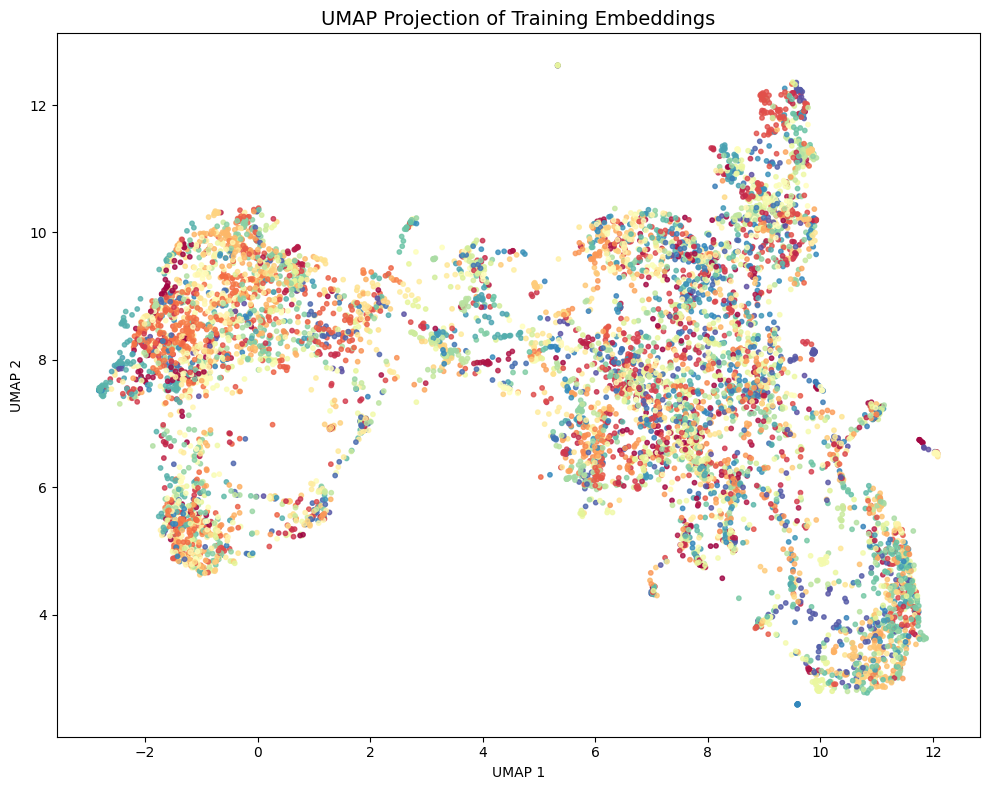

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import LabelEncoder

# Extract embeddings and labels
embeddings = np.vstack(train_dataset.df['embedding'].values)
labels = train_dataset.df['category_id'].values

# Encode labels to integers if not already
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Reduce to 2D using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=encoded_labels,
    cmap='Spectral',
    s=10,
    alpha=0.8
)

plt.title("UMAP Projection of Training Embeddings", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Optional: show legend only if number of classes is small
num_classes = len(np.unique(labels))
if num_classes <= 20:
    # Create legend with label names
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          label=label_encoder.inverse_transform([i])[0],
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=6)
               for i in range(num_classes)]
    plt.legend(handles=handles, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Meta Baseline

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR # Added for LR scheduling
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm
from typing import List, Tuple, Optional # Added Tuple
from collections import defaultdict # Added missing import

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class MLPEmbedder(nn.Module):
    """MLP embedder network with improved architecture for feature transformation."""
    def __init__(self, input_dim: int, hidden_dims: List[int], output_dim: int, 
                 dropout: float = 0.1, use_batch_norm: bool = True, 
                 activation: nn.Module = nn.ReLU()):
        super(MLPEmbedder, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers with optional batch normalization
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Add batch normalization before activation
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            # Add activation
            layers.append(activation)
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.embedder = nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the embedder.
        Args:
            x: Input tensor.
        Returns:
            L2 normalized embeddings.
        """
        embedded = self.embedder(x)
        # L2 normalize embeddings
        return F.normalize(embedded, p=2, dim=1)


class WholeClassifier(nn.Module):
    """Classifier for the whole-classification training stage with improved design."""
    def __init__(self, embedder: nn.Module, output_dim: int, embedding_dim: Optional[int] = None):
        super(WholeClassifier, self).__init__()
        self.embedder = embedder
        
        # If embedding_dim is not provided, infer it from the embedder
        if embedding_dim is None:
            # Get the output dimension from the last linear layer of the embedder
            # This assumes the last layer of embedder.embedder is nn.Linear
            for layer in reversed(list(embedder.embedder.children())):
                if isinstance(layer, nn.Linear):
                    embedding_dim = layer.out_features
                    break
            if embedding_dim is None:
                raise ValueError("Could not infer embedding_dim from embedder.")

        # Add a classifier head with higher capacity
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embedding_dim // 2, output_dim)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the embedder and classifier head.
        Args:
            x: Input tensor.
        Returns:
            Logits from the classifier.
        """
        embedded = self.embedder(x)
        return self.classifier(embedded)

class EmbeddingDataset(Dataset):
    """Dataset for loading embeddings and their categories."""
    def __init__(self, dataframe: pd.DataFrame):
        """
        Args:
            dataframe: Pandas DataFrame with 'embedding' and 'category_id' columns.
        """
        # Ensure embeddings are stored as numpy arrays if they aren't already
        if not isinstance(dataframe['embedding'].iloc[0], np.ndarray):
            self.embeddings = np.stack(dataframe['embedding'].apply(lambda x: np.array(x, dtype=np.float32)).values)
        else:
            self.embeddings = np.stack(dataframe['embedding'].values)
        self.labels = dataframe['category_id'].values
        
    def __len__(self) -> int:
        return len(self.embeddings)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = self.labels[idx]
        return embedding, label

def recall_at_k_from_prototypes(query_embeddings: torch.Tensor, query_labels: torch.Tensor,
                                  support_embeddings: torch.Tensor, support_labels: torch.Tensor, 
                                  k: int = 5) -> float:
    """
    Calculate recall@k of query embeddings against class prototypes computed from support embeddings.
    
    Args:
        query_embeddings: Tensor of shape (n_queries, embedding_dim)
        query_labels: Tensor of shape (n_queries,)
        support_embeddings: Tensor of shape (n_support, embedding_dim)
        support_labels: Tensor of shape (n_support,)
        k: k for recall@k
        
    Returns:
        recall@k value as a float
    """
    # Ensure embeddings are normalized (already done by embedder, but good practice for standalone use)
    query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
    support_embeddings = F.normalize(support_embeddings, p=2, dim=1)

    # Compute class prototypes from support embeddings
    unique_classes_support = torch.unique(support_labels)
    prototypes = []
    prototype_labels = [] # Store the original labels corresponding to prototypes

    for cls_label in unique_classes_support:
        cls_mask = support_labels == cls_label
        if cls_mask.sum() > 0:  # Ensure we have samples for this class
            cls_proto = support_embeddings[cls_mask].mean(dim=0)
            cls_proto = F.normalize(cls_proto, p=2, dim=0)  # Ensure prototype is normalized
            prototypes.append(cls_proto)
            prototype_labels.append(cls_label) 
    
    if len(prototypes) == 0:
        return 0.0
        
    prototypes = torch.stack(prototypes)  # (C, D)
    prototype_labels = torch.tensor(prototype_labels, device=prototypes.device) # (C,)

    # Cosine similarity: (Nq, C)
    # Since embeddings and prototypes are L2 normalized, matmul gives cosine similarity
    sim = torch.matmul(query_embeddings, prototypes.T)

    # Top-k prediction indices (indices into the prototypes tensor)
    topk_pred_indices = torch.topk(sim, min(k, prototypes.shape[0]), dim=1).indices # prototypes.shape[0] is num unique classes in support

    # Get the actual class labels of the top-k predicted prototypes
    topk_pred_labels = prototype_labels[topk_pred_indices] # (Nq, k)

    # Compute recall@k
    # Check if the true query label is among the top-k predicted labels
    correct = (topk_pred_labels == query_labels.unsqueeze(1)).any(dim=1).float()
    
    if len(correct) == 0: # Should not happen if query_labels is not empty
        return 0.0
        
    return correct.mean().item()


class MetaDataset(Dataset):
    """
    Dataset for meta-learning with improved episode sampling and augmentation.
    """
    def __init__(self, embeddings: torch.Tensor, labels: torch.Tensor, 
                 n_way: int = 5, k_shot: int = 5, n_query: int = 15,
                 num_tasks_per_epoch: int = 1000, # Added for clarity
                 augment_support: bool = False, augment_query: bool = False,
                 noise_std: float = 0.01):
        """
        Initialize meta-dataset.
        
        Args:
            embeddings: Tensor of shape (n_samples, embedding_dim)
            labels: Tensor of shape (n_samples,)
            n_way: Number of classes per episode
            k_shot: Number of support samples per class
            n_query: Number of query samples per class
            num_tasks_per_epoch: Number of tasks (episodes) to generate for one pass of DataLoader.
            augment_support: Whether to augment support set
            augment_query: Whether to augment query set
            noise_std: Standard deviation of Gaussian noise for augmentation
        """
        self.embeddings = embeddings
        self.labels = labels
        self.n_way = n_way
        self.k_shot = k_shot
        self.n_query = n_query
        self.num_tasks_per_epoch = num_tasks_per_epoch
        self.augment_support = augment_support
        self.augment_query = augment_query
        self.noise_std = noise_std
        
        # Get unique labels and build class indices mapping
        self.unique_labels = torch.unique(self.labels).tolist()
        
        # Ensure we have enough classes
        if len(self.unique_labels) < self.n_way:
            raise ValueError(f"Dataset has only {len(self.unique_labels)} classes, but n_way={self.n_way}")
        
        # Build class-to-indices mapping for efficient sampling
        self.class_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels.tolist()):
            self.class_to_indices[label].append(idx)
        
        # Filter out classes with too few samples
        min_samples_per_class = k_shot + n_query
        self.viable_classes = [cls for cls in self.unique_labels 
                               if len(self.class_to_indices[cls]) >= min_samples_per_class]
        
        if len(self.viable_classes) < self.n_way:
            print(f"Warning: Only {len(self.viable_classes)} classes have enough samples for {k_shot}-shot + {n_query}-query. "
                  f"Will sample classes with replacement if necessary.")
    
    def __len__(self) -> int:
        # Number of tasks (episodes) generated by this dataset object for one epoch of training
        return self.num_tasks_per_epoch 
    
    def apply_augmentation(self, embeddings: torch.Tensor) -> torch.Tensor:
        """Apply Gaussian noise augmentation and re-normalize."""
        noise = torch.randn_like(embeddings) * self.noise_std
        augmented = embeddings + noise
        return F.normalize(augmented, p=2, dim=1) # Re-normalize after adding noise
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # This idx is just a dummy to satisfy DataLoader, actual sampling is random per call.
        
        # Sample n_way classes
        if len(self.viable_classes) >= self.n_way:
            # Prefer sampling from viable classes without replacement if possible
            selected_class_labels = np.random.choice(self.viable_classes, self.n_way, replace=False)
        else:
            # Fallback: sample with replacement from all unique labels
            selected_class_labels = np.random.choice(self.unique_labels, self.n_way, replace=True)
        
        support_embeddings_task = []
        support_labels_task = []
        query_embeddings_task = []
        query_labels_task = []
        
        for relative_label_idx, class_label in enumerate(selected_class_labels):
            # Get indices of all samples with this class_label
            class_indices = self.class_to_indices[class_label]
            
            num_samples_for_class = self.k_shot + self.n_query
            
            if len(class_indices) < num_samples_for_class:
                # Sample with replacement if not enough unique samples
                sampled_indices_for_class = np.random.choice(class_indices, num_samples_for_class, replace=True)
            else:
                # Sample without replacement
                sampled_indices_for_class = np.random.choice(class_indices, num_samples_for_class, replace=False)
            
            support_indices = sampled_indices_for_class[:self.k_shot]
            query_indices = sampled_indices_for_class[self.k_shot : self.k_shot + self.n_query]
            
            # Add to support set for the current task
            for sample_idx in support_indices:
                emb = self.embeddings[sample_idx]
                if self.augment_support:
                    emb = self.apply_augmentation(emb.unsqueeze(0)).squeeze(0) # Augment one sample at a time
                support_embeddings_task.append(emb)
                support_labels_task.append(relative_label_idx) # Use relative label (0 to n_way-1)
            
            # Add to query set for the current task
            for sample_idx in query_indices:
                emb = self.embeddings[sample_idx]
                if self.augment_query:
                    emb = self.apply_augmentation(emb.unsqueeze(0)).squeeze(0) # Augment one sample at a time
                query_embeddings_task.append(emb)
                query_labels_task.append(relative_label_idx) # Use relative label (0 to n_way-1)
        
        # Convert to tensors
        # Ensure all tensors are on the same device as self.embeddings if it's already on GPU
        # However, typical Datasets return CPU tensors, and DataLoader handles pinning memory / moving to GPU
        support_embeddings_task = torch.stack(support_embeddings_task)
        support_labels_task = torch.tensor(support_labels_task, dtype=torch.long)
        query_embeddings_task = torch.stack(query_embeddings_task)
        query_labels_task = torch.tensor(query_labels_task, dtype=torch.long)
        
        return support_embeddings_task, support_labels_task, query_embeddings_task, query_labels_task

def train_classifier_baseline(embedder: MLPEmbedder, train_loader: DataLoader, val_loader: DataLoader, 
                              num_epochs: int = 100,
                              device: str = 'cuda'):
    """Train the classifier baseline (whole-classification)."""
    print("Starting Classifier Baseline Training...")

    # Count unique labels in training set
    all_train_labels = []
    for _, labels_batch in train_loader:
        all_train_labels.extend(labels_batch.cpu().numpy())
    if not all_train_labels:
        raise ValueError("Training loader is empty or labels are not being yielded correctly.")
    num_classes = len(np.unique(all_train_labels))
    
    classifier = WholeClassifier(embedder, num_classes).to(device)
    
    optimizer = optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    best_embedder_state = None
    
    for epoch in range(num_epochs):
        classifier.train()
        train_loss_epoch = 0.0
        
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = classifier(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss_epoch += loss.item()
        
        train_loss_epoch /= len(train_loader)
        
        # Validation
        classifier.eval()
        val_loss_epoch = 0.0
        all_preds_val = []
        all_labels_val = []
        
        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = classifier(embeddings)
                loss = criterion(outputs, labels)
                val_loss_epoch += loss.item()
                
                _, preds = torch.max(outputs, 1)
                all_preds_val.extend(preds.cpu().numpy())
                all_labels_val.extend(labels.cpu().numpy())
        
        val_loss_epoch /= len(val_loader)
        val_acc_epoch = accuracy_score(all_labels_val, all_preds_val)
        
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_epoch:.4f}, "
                  f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}, "
                  f"LR: {scheduler.get_last_lr()[0]:.6f}")
        
        scheduler.step()

        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            best_embedder_state = embedder.state_dict()
            
    if best_embedder_state:
        embedder.load_state_dict(best_embedder_state)
        print(f"Loaded best embedder state from epoch with Val Loss: {best_val_loss:.4f}")
    else:
        print("Warning: No best model state was saved (validation loss might not have improved).")
        
    return embedder

class ProtoLoss(nn.Module):
    """Prototypical Networks loss with learnable temperature scaling."""
    def __init__(self, init_temp: float = 10.0):
        super(ProtoLoss, self).__init__()
        # Ensure temperature is positive by clamping or using softplus if it can go too low
        self.temperature = nn.Parameter(torch.tensor(init_temp)) 
        
    def forward(self, support_features: torch.Tensor, support_labels: torch.Tensor, 
                query_features: torch.Tensor, query_labels: torch.Tensor) -> torch.Tensor:
        """
        Compute prototypical loss. Assumes features are already L2 normalized.
        
        Args:
            support_features: Support set features of shape (n_support_total, embedding_dim)
            support_labels: Support set labels (relative, 0 to n_way-1) of shape (n_support_total,)
            query_features: Query set features of shape (n_query_total, embedding_dim)
            query_labels: Query set labels (relative, 0 to n_way-1) of shape (n_query_total,)
            
        Returns:
            Loss value
        """
        # support_features and query_features are expected to be normalized by the embedder
        
        # Calculate prototypes for each class in the task
        # These are relative labels (0 to n_way-1)
        unique_task_classes = torch.unique(support_labels) 
        n_task_classes = len(unique_task_classes) # Should be n_way
        
        prototypes = torch.stack([
            support_features[support_labels == i].mean(dim=0) 
            for i in unique_task_classes # Iterate using actual unique labels in the task
        ]) # Shape: (n_task_classes, embedding_dim)
        
        # Normalize prototypes: mean of normalized vectors is not necessarily normalized
        prototypes = F.normalize(prototypes, p=2, dim=1) # Added normalization
        
        # Compute distances (or similarities) between query samples and prototypes
        # Using dot product for similarity as features and prototypes are L2 normalized
        # logits = torch.matmul(query_features, prototypes.T) * torch.clamp(self.temperature, min=1.0) # Cosine similarity scaled by temperature
        
        # Alternative: Euclidean distance based (as in original, but with normalized prototypes)
        dists = torch.cdist(query_features, prototypes, p=2) # (n_query_total, n_task_classes)
        logits = -dists * torch.clamp(self.temperature, min=1.0) # Scale negative distance

        # Map query_labels to be 0 to n_task_classes-1 if they are not already
        # The MetaDataset already provides relative labels, so this should be fine.
        # If query_labels might not align perfectly with unique_task_classes indices, remapping would be needed.
        # However, MetaDataset ensures this by using relative_label_idx.

        loss = F.cross_entropy(logits, query_labels)
        return loss
            
def train_meta_baseline(embedder: MLPEmbedder, 
                        train_embeddings_raw: torch.Tensor, train_labels_raw: torch.Tensor, 
                        val_embeddings_raw: torch.Tensor, val_labels_raw: torch.Tensor,
                        n_way: int = 5, k_shot: int = 5, n_query: int = 15, 
                        meta_epochs: int = 50,
                        tasks_per_meta_epoch: int = 200,
                        inner_epochs_per_meta_epoch: int = 4,
                        device: str = 'cuda'):
    """Train the meta-baseline model episodically without early stopping."""
    print("Starting Meta-Learning Training...")
    embedder = embedder.to(device)
    
    optimizer = optim.AdamW(embedder.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=meta_epochs * inner_epochs_per_meta_epoch, eta_min=1e-7)

    proto_loss_fn = ProtoLoss(init_temp=10.0).to(device)
    optimizer.add_param_group({'params': proto_loss_fn.parameters(), 'lr': optimizer.defaults['lr'] * 0.1})

    for meta_epoch_idx in range(meta_epochs):
        print(f"\nMeta-Epoch {meta_epoch_idx + 1}/{meta_epochs}")
        
        meta_train_dataset = MetaDataset(train_embeddings_raw.cpu(), train_labels_raw.cpu(), 
                                         n_way, k_shot, n_query,
                                         num_tasks_per_epoch=tasks_per_meta_epoch,
                                         augment_support=True, augment_query=False)
        meta_train_loader = DataLoader(meta_train_dataset, batch_size=1, shuffle=True, num_workers=2, 
                                       pin_memory=(device == 'cuda'))

        for inner_epoch_idx in range(inner_epochs_per_meta_epoch):
            embedder.train()
            proto_loss_fn.train()
            total_train_loss = 0.0

            for batch in meta_train_loader:
                support_data_task, support_labels_task, query_data_task, query_labels_task = batch
                support_data_task = support_data_task.squeeze(0).to(device)
                support_labels_task = support_labels_task.squeeze(0).to(device)
                query_data_task = query_data_task.squeeze(0).to(device)
                query_labels_task = query_labels_task.squeeze(0).to(device)

                optimizer.zero_grad()
                support_features = embedder(support_data_task)
                query_features = embedder(query_data_task)
                loss = proto_loss_fn(support_features, support_labels_task, query_features, query_labels_task)
                loss.backward()
                optimizer.step()
                scheduler.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(meta_train_loader)
            print(f"  Inner Epoch {inner_epoch_idx + 1}/{inner_epochs_per_meta_epoch} - Avg Loss: {avg_train_loss:.4f}")

        # Validation
        embedder.eval()
        proto_loss_fn.eval()
        with torch.no_grad():
            val_features = torch.cat([
                embedder(val_embeddings_raw[i:i + 256].to(device)).cpu()
                for i in range(0, val_embeddings_raw.shape[0], 256)
            ], dim=0)

            train_features = torch.cat([
                embedder(train_embeddings_raw[i:i + 256].to(device)).cpu()
                for i in range(0, train_embeddings_raw.shape[0], 256)
            ], dim=0)

            val_recall = recall_at_k_from_prototypes(
                query_embeddings=val_features,
                query_labels=val_labels_raw.cpu(),
                support_embeddings=train_features,
                support_labels=train_labels_raw.cpu(),
                k=5
            )

        print(f"  Validation Recall@5: {val_recall:.4f}")

    return embedder

def main(train_df: pd.DataFrame, val_df: pd.DataFrame, 
         input_dim: int = 768, hidden_dims: List[int] = [512, 256], output_dim: int = 128,
         classifier_epochs: int = 200, # Adjusted
         meta_training_epochs: int = 20, # Adjusted
         tasks_per_meta_ep: int = 200,
         inner_epochs_meta: int = 2
         ):
    """Main function to load data, pre-train embedder, and then meta-train."""    
    print(f"Train dataset shape: {train_df.shape}")
    print(f"Validation dataset shape: {val_df.shape}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create datasets for classifier pre-training
    train_classifier_dataset = EmbeddingDataset(train_df)
    val_classifier_dataset = EmbeddingDataset(val_df)
    
    # Create data loaders for classifier pre-training
    # Consider using more workers if data loading is a bottleneck
    train_classifier_loader = DataLoader(train_classifier_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True if device=='cuda' else False)
    val_classifier_loader = DataLoader(val_classifier_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True if device=='cuda' else False)
    
    # --- Stage 1: Pre-train Embedder using Whole Classifier ---
    print("\n--- Stage 1: Training Classifier Baseline (Pre-training Embedder) ---")
    # Initialize a new embedder for pre-training
    embedder_for_pretrain = MLPEmbedder(input_dim, hidden_dims, output_dim, dropout=0.2, use_batch_norm=True).to(device)
    
    # Train the classifier, which in turn trains the embedder
    # The train_classifier_baseline function will load the best embedder state into embedder_for_pretrain
    embedder_for_pretrain = train_classifier_baseline(embedder_for_pretrain, 
                                                      train_classifier_loader, val_classifier_loader, 
                                                      num_epochs=classifier_epochs, device=device)
    
    # --- Evaluate Pre-trained Embedder (Optional) ---
    print("\n--- Evaluating Pre-trained Embedder on Recall@5 (using training set as support) ---")
    embedder_for_pretrain.eval()
    with torch.no_grad():
        # Extract all embeddings and labels using the pre-trained embedder
        all_train_embeddings_list_pt = []
        all_train_labels_list_pt = []
        for emb_batch, lbl_batch in tqdm(train_classifier_loader, desc="Extracting pre-trained train embeddings"):
            all_train_embeddings_list_pt.append(embedder_for_pretrain(emb_batch.to(device)).cpu())
            all_train_labels_list_pt.append(lbl_batch.cpu())
        
        all_train_embeddings_pt = torch.cat(all_train_embeddings_list_pt, dim=0)
        all_train_labels_pt = torch.cat(all_train_labels_list_pt, dim=0)

        all_val_embeddings_list_pt = []
        all_val_labels_list_pt = []
        for emb_batch, lbl_batch in tqdm(val_classifier_loader, desc="Extracting pre-trained val embeddings"):
            all_val_embeddings_list_pt.append(embedder_for_pretrain(emb_batch.to(device)).cpu())
            all_val_labels_list_pt.append(lbl_batch.cpu())
        all_val_embeddings_pt = torch.cat(all_val_embeddings_list_pt, dim=0)
        all_val_labels_pt = torch.cat(all_val_labels_list_pt, dim=0)

        pretrain_recall = recall_at_k_from_prototypes(
            query_embeddings=all_val_embeddings_pt,
            query_labels=all_val_labels_pt,
            support_embeddings=all_train_embeddings_pt,
            support_labels=all_train_labels_pt,
            k=5,
        )
        print(f"Pre-trained Embedder Recall@5 (Val queries, Train support): {pretrain_recall:.4f}")

    # --- Stage 2: Meta-Train the Embedder ---
    print("\n--- Stage 2: Training Meta Baseline ---")
    # Prepare raw (original, pre-embedder) data for meta-training
    # These are the embeddings that go INTO the embedder
    raw_train_embeddings_for_meta = torch.tensor(train_classifier_dataset.embeddings, dtype=torch.float32)
    raw_train_labels_for_meta = torch.tensor(train_classifier_dataset.labels, dtype=torch.long)
    raw_val_embeddings_for_meta = torch.tensor(val_classifier_dataset.embeddings, dtype=torch.float32)
    raw_val_labels_for_meta = torch.tensor(val_classifier_dataset.labels, dtype=torch.long)

    # We use the pre-trained embedder as initialization for meta-training
    # Make a deepcopy if you want to keep the original pre-trained one separate,
    # but train_meta_baseline will modify the passed embedder object.
    meta_trained_embedder = embedder_for_pretrain # Continue training this embedder

    meta_trained_embedder = train_meta_baseline(
        meta_trained_embedder,
        raw_train_embeddings_for_meta, raw_train_labels_for_meta,
        raw_val_embeddings_for_meta, raw_val_labels_for_meta,
        n_way=5, k_shot=5, n_query=15, # Standard few-shot parameters
        meta_epochs=meta_training_epochs, 
        tasks_per_meta_epoch=tasks_per_meta_ep,
        inner_epochs_per_meta_epoch=inner_epochs_meta,
        device=device
    )

    # --- Final Evaluation of Meta-Trained Embedder ---
    print("\n--- Final Evaluation of Meta-Trained Embedder ---")
    meta_trained_embedder.eval()
    with torch.no_grad():
        # Get features for val set using the final meta-trained embedder
        final_val_features_list = []
        val_bs = 256
        for i in range(0, raw_val_embeddings_for_meta.shape[0], val_bs):
            batch_val_emb = raw_val_embeddings_for_meta[i:i+val_bs].to(device)
            final_val_features_list.append(meta_trained_embedder(batch_val_emb).cpu())
        final_val_features = torch.cat(final_val_features_list, dim=0)

        # Get features for train set using the final meta-trained embedder (to act as support)
        final_train_features_list = []
        for i in range(0, raw_train_embeddings_for_meta.shape[0], val_bs):
            batch_train_emb = raw_train_embeddings_for_meta[i:i+val_bs].to(device)
            final_train_features_list.append(meta_trained_embedder(batch_train_emb).cpu())
        final_train_features = torch.cat(final_train_features_list, dim=0)
        
        final_recall = recall_at_k_from_prototypes(
            query_embeddings=final_val_features,
            query_labels=raw_val_labels_for_meta.cpu(),
            support_embeddings=final_train_features,
            support_labels=raw_train_labels_for_meta.cpu(),
            k=5,
        )
        print(f"Final Meta-Trained Embedder Recall@5 (Val queries, Train support): {final_recall:.4f}")

    # Save the final meta-trained model
    model_save_path = 'meta_baseline_embedder_final.pth'
    torch.save(meta_trained_embedder.state_dict(), model_save_path)
    print(f"Final meta-trained model saved as '{model_save_path}'")
    
    return meta_trained_embedder

In [37]:
import pandas as pd
import torch

# Example usage

# Step 1: Load your datasets (assuming they have 'embedding' and 'category_id' columns)
train_df = train_dataset.df
val_df = val_dataset.df

# Step 2: Determine the embedding dimensions
# Inspect one embedding to get the input dimension
input_dim = len(train_df['embedding'].iloc[0])
print(f"Input embedding dimension: {input_dim}")

# Step 3: Train the model
embedder = main(train_df, val_df, 
               input_dim=input_dim,  # Usually 768 for BERT, 1024 for EfficientNet, etc.
               hidden_dims=[512],  # Customize as needed
               output_dim=512)  # Final embedding dimension

Input embedding dimension: 2271
Train dataset shape: (7819, 107)
Validation dataset shape: (2285, 109)
Using device: cuda

--- Stage 1: Training Classifier Baseline (Pre-training Embedder) ---
Starting Classifier Baseline Training...
Epoch 1/200, Train Loss: 7.5097, Val Loss: 7.6104, Val Acc: 0.0284, LR: 0.001000
Epoch 10/200, Train Loss: 0.5277, Val Loss: 4.9256, Val Acc: 0.1821, LR: 0.000995
Epoch 20/200, Train Loss: 0.0345, Val Loss: 5.0741, Val Acc: 0.1952, LR: 0.000978
Epoch 30/200, Train Loss: 0.0143, Val Loss: 5.1583, Val Acc: 0.1934, LR: 0.000949
Epoch 40/200, Train Loss: 0.0077, Val Loss: 5.2620, Val Acc: 0.1921, LR: 0.000909
Epoch 50/200, Train Loss: 0.0052, Val Loss: 5.3313, Val Acc: 0.1917, LR: 0.000859
Epoch 60/200, Train Loss: 0.0036, Val Loss: 5.3691, Val Acc: 0.1947, LR: 0.000800
Epoch 70/200, Train Loss: 0.0028, Val Loss: 5.3882, Val Acc: 0.1978, LR: 0.000734
Epoch 80/200, Train Loss: 0.0021, Val Loss: 5.4608, Val Acc: 0.1912, LR: 0.000662
Epoch 90/200, Train Loss: 0.0

Extracting pre-trained val embeddings: 100%|██████████| 9/9 [00:00<00:00, 46.65it/s]


Pre-trained Embedder Recall@5 (Val queries, Train support): 0.3672

--- Stage 2: Training Meta Baseline ---
Starting Meta-Learning Training...

Meta-Epoch 1/20
  Inner Epoch 1/2 - Avg Loss: 0.0136
  Inner Epoch 2/2 - Avg Loss: 0.0114
  Validation Recall@5: 0.3777

Meta-Epoch 2/20
  Inner Epoch 1/2 - Avg Loss: 0.0092
  Inner Epoch 2/2 - Avg Loss: 0.0071
  Validation Recall@5: 0.3786

Meta-Epoch 3/20
  Inner Epoch 1/2 - Avg Loss: 0.0047
  Inner Epoch 2/2 - Avg Loss: 0.0060
  Validation Recall@5: 0.3847

Meta-Epoch 4/20
  Inner Epoch 1/2 - Avg Loss: 0.0118
  Inner Epoch 2/2 - Avg Loss: 0.0079
  Validation Recall@5: 0.3829

Meta-Epoch 5/20
  Inner Epoch 1/2 - Avg Loss: 0.0092
  Inner Epoch 2/2 - Avg Loss: 0.0054
  Validation Recall@5: 0.3873

Meta-Epoch 6/20
  Inner Epoch 1/2 - Avg Loss: 0.0061
  Inner Epoch 2/2 - Avg Loss: 0.0086
  Validation Recall@5: 0.3860

Meta-Epoch 7/20
  Inner Epoch 1/2 - Avg Loss: 0.0034
  Inner Epoch 2/2 - Avg Loss: 0.0087
  Validation Recall@5: 0.3838

Meta-Epoc

In [38]:
train_dataset_meta = FungiTasticAugmented(root=data_path, split='train', transform=None)
test_dataset_meta = FungiTasticAugmented(root=data_path, split='test', transform=None)
val_dataset_meta = FungiTasticAugmented(root=data_path, split='val', transform=None)
train_dataset_meta.df.head()

,eventDate,year,month,day,habitat,countryCode,scientificName,kingdom,phylum,class,...,substrate_peat mosses,substrate_remains of vertebrates (e.g. feathers and fur),substrate_siliceous stone,substrate_soil,substrate_spiders,"substrate_stems of herbs, grass etc",substrate_stone,substrate_unknown_substrate,substrate_wood and roots of living trees,substrate_wood chips or mulch
0,2021-01-24,2021,1.0,24.0,Mixed woodland (with coniferous and deciduous ...,DK,Xylohypha ferruginosa (Corda) S.Hughes,Fungi,Ascomycota,Eurotiomycetes,...,False,False,False,False,False,False,False,False,False,False
1,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,False,False,False,False,False,False,False,False,False,False
2,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,False,False,False,False,False,False,False,False,False,False
3,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,False,False,False,False,False,False,False,False,False,False
4,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,False,False,False,False,False,False,False,False,False,False


In [39]:
def replace_embeddings_in_meta(dataset, dataset_meta, embedder, batch_size=256):
    embedder.eval()
    all_embeddings = []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch_embeddings = dataset.df['embedding'].iloc[i:i+batch_size].tolist()
            batch_embeddings = torch.stack([torch.tensor(e, dtype=torch.float32) for e in batch_embeddings])
            batch_embeddings = batch_embeddings.to(next(embedder.parameters()).device)

            new_embeddings = embedder(batch_embeddings).cpu()
            all_embeddings.extend(new_embeddings)

    dataset_meta.df['embedding'] = all_embeddings
    return dataset_meta

In [40]:
train_dataset_meta = replace_embeddings_in_meta(train_dataset, train_dataset_meta, embedder)
val_dataset_meta = replace_embeddings_in_meta(val_dataset, val_dataset_meta, embedder)
test_dataset_meta = replace_embeddings_in_meta(test_dataset, test_dataset_meta, embedder)

In [41]:
cls, conf = classify_dataset(train_dataset_meta, test_dataset_meta, device='cpu')

In [42]:
import numpy as np
import pandas as pd
from collections import defaultdict

# Assign predicted classes and confidences to the DataFrame
test_dataset_meta.df["preds"] = cls.tolist()  # shape: (N, 10)
test_dataset_meta.df["conf"] = conf.tolist()  # shape: (N, 10)

observationIDs = np.array(test_dataset_meta.df['observationID'])

# Weight values based on descending rank
rank_weights = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])

# Container for final predictions
final_predictions = []

# Process each unique observation ID
for obs_id in np.unique(observationIDs):
    idx = observationIDs == obs_id
    preds = np.array(test_dataset_meta.df.loc[idx, "preds"].tolist())  # shape: (k, 10)
    confs = np.array(test_dataset_meta.df.loc[idx, "conf"].tolist())  # shape: (k, 10)

    # For each row, sort confidences and reorder preds and confs accordingly
    weighted_scores = defaultdict(float)

    for i in range(preds.shape[0]):
        sorted_idx = np.argsort(-confs[i])  # Descending sort
        sorted_preds = preds[i][sorted_idx]
        for rank, cls_id in enumerate(sorted_preds):
            weighted_scores[cls_id] += rank_weights[rank]

    # Sort classes by total weighted score
    sorted_classes = sorted(weighted_scores.items(), key=lambda x: -x[1])
    top_10_classes = [str(cls_id) for cls_id, _ in sorted_classes[:10]]

    final_predictions.append(' '.join(top_10_classes))

# Final submission DataFrame
submission = pd.DataFrame({
    'observationId': np.unique(observationIDs),
    'predictions': final_predictions
})

submission.to_csv("refined_metadata_submission.csv", index=False)

In [43]:
cls, conf = classify_dataset(train_dataset_meta, val_dataset_meta, device='cpu')

In [44]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Step 1: Assign predictions and confidences
val_dataset_meta.df["preds"] = cls.tolist()  # shape: (N, 10)
val_dataset_meta.df["conf"] = conf.tolist()  # shape: (N, 10)

observationIDs = np.array(val_dataset_meta.df["observationID"])
unique_ids = np.unique(observationIDs)

# Define rank-based weights
rank_weights = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])

# Step 2: Aggregate predictions
final_predictions = []
true_labels = []
recall_at_5_count = 0

for obs_id in unique_ids:
    idx = observationIDs == obs_id
    preds = np.array(val_dataset_meta.df.loc[idx, "preds"].tolist())  # shape: (k, 10)
    confs = np.array(val_dataset_meta.df.loc[idx, "conf"].tolist())  # shape: (k, 10)

    # Aggregate weighted scores across rows
    weighted_scores = defaultdict(float)
    for i in range(preds.shape[0]):
        sorted_idx = np.argsort(-confs[i])  # descending confidence
        sorted_preds = preds[i][sorted_idx]
        for rank, cls_id in enumerate(sorted_preds):
            weighted_scores[cls_id] += rank_weights[rank]

    # Sort by total score and select top-10
    sorted_classes = sorted(weighted_scores.items(), key=lambda x: -x[1])
    top_preds = [str(cls_id) for cls_id, _ in sorted_classes[:10]]
    final_predictions.append(" ".join(top_preds))

    # Step 3: Get ground truth and compute Recall@5
    true_label = val_dataset_meta.df[val_dataset_meta.df["observationID"] == obs_id]["category_id"].iloc[0]
    true_labels.append(true_label)

    if str(true_label) in top_preds[:5]:
        recall_at_5_count += 1

# Step 4: Final dataframe and Recall@5
final_val = pd.DataFrame({
    "observationId": unique_ids,
    "predictions": final_predictions
})

recall_at_5 = recall_at_5_count / len(true_labels)
print(f"Recall@5: {recall_at_5:.4f}")

Recall@5: 0.4659


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


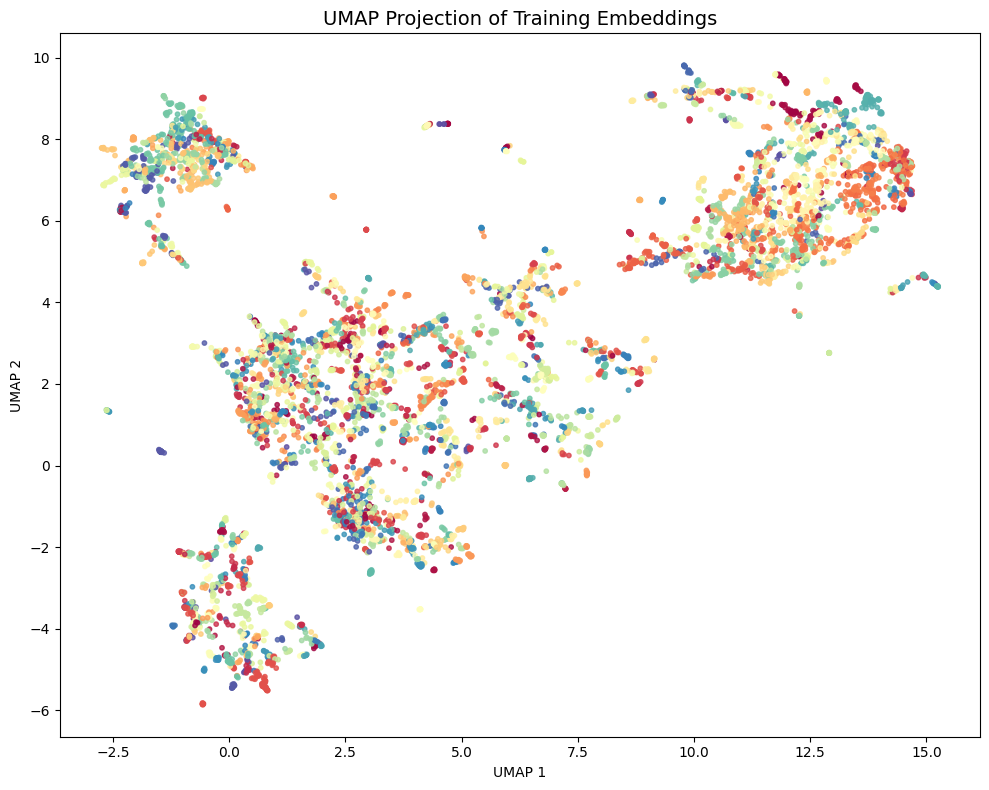

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import LabelEncoder

# Extract embeddings and labels
embeddings = np.vstack(train_dataset_meta.df['embedding'].values)
labels = train_dataset_meta.df['category_id'].values

# Encode labels to integers if not already
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Reduce to 2D using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=encoded_labels,
    cmap='Spectral',
    s=10,
    alpha=0.8
)

plt.title("UMAP Projection of Training Embeddings", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Optional: show legend only if number of classes is small
num_classes = len(np.unique(labels))
if num_classes <= 20:
    # Create legend with label names
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          label=label_encoder.inverse_transform([i])[0],
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=6)
               for i in range(num_classes)]
    plt.legend(handles=handles, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()